In [2]:
from typing import Callable, Sequence, Any
from functools import partial
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from aa_train_utils.model_utils import create_model, save_model_params, load_model_params
from aa_train_utils.dataset_generation import joint, uniform, f6, f5, f2, RegressionDataset , generate_noisy_split_trainingdata
from aa_train_utils.spl_curriculum import SPL_curriculum 

import jax
import jax.numpy as jnp
import jax.tree_util
from jax.scipy.stats.norm import logpdf
from scipy.stats import t
import pickle

import numpy as np
import pickle
import flax
import flax.linen as nn

import optax
import jaxopt
import netket as nk

import tqdm

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # Import Line2D for custom legend entry
import seaborn as sns

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
#from dataloader import MixtureDataset
import pandas as pd
from jax.tree_util import tree_map


2024-06-18 20:21:48.619782: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[10.0, 28.0, 46.0, 64.0, 82.0, 100.0]
[ 100  380  839 1479 2299 3298]


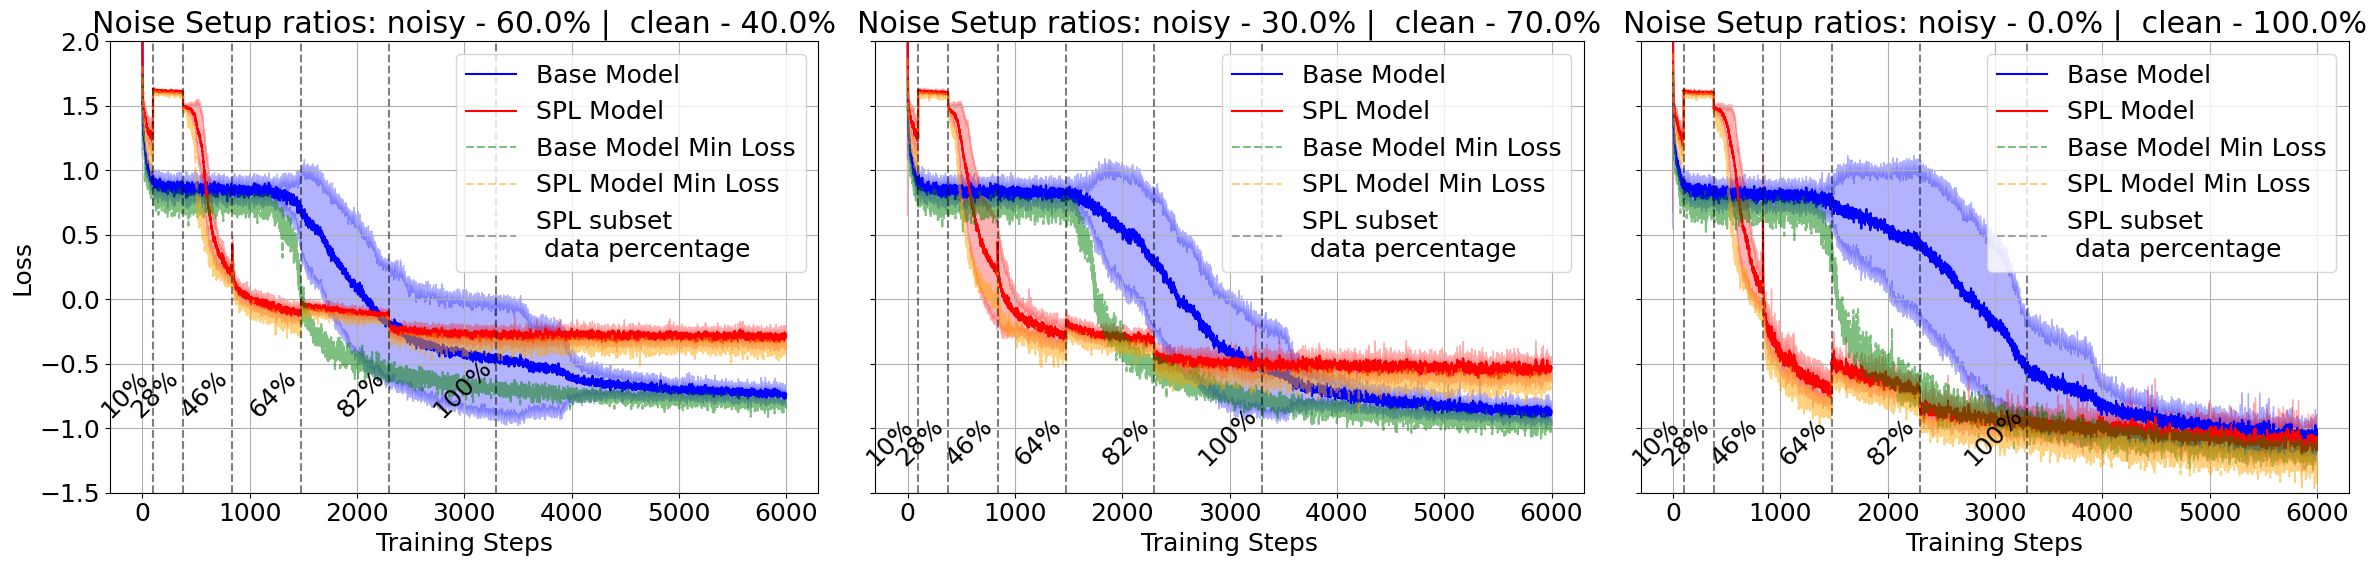

In [9]:
# Firstly we will need to load in the necessary training metrics for a single run. 

# for baseline this takes the form within a given folder (base_0_1)

# Set the experiment directory
experiment_directory = "exp_ds_10runs"

# Lets also load in the curricula weights , its enough to load it in for one , becauase they used the same curricula params. 

spl_logs_path = os.path.join(experiment_directory, "noise_0_1_runs", "spl_0_1_1_curricula_logs.pkl")

batch_size= 128

dataset_size= 128*1000
# Load in 
with open(spl_logs_path, "rb") as f:
    spl_logs_data = pickle.load(f)

spl_subset_percentages = [round(len(w)/dataset_size*100,2) for w in spl_logs_data["curricula_weights"]]
print(spl_subset_percentages)
spl_subset_lengths=np.cumsum([len(w)//128 for w  in spl_logs_data["curricula_weights"]])
print(spl_subset_lengths)

# Get the list of noise setup directories
noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]

# Define the number of noise setups
num_noise_setups = len(noise_setup_directories)


plt.rcParams.update({'font.size': 18})
# Create a figure with subplots for each noise setup
fig, axs = plt.subplots(1, num_noise_setups, figsize=(8 * num_noise_setups, 6), sharey=True)

# Iterate over each noise setup directory
for i, noise_setup_directory in enumerate(noise_setup_directories):
    # Extract noise levels from directory name
    noise_levels = noise_setup_directory.split("_")[1:-1]

    # Initialize lists to store losses for each model
    base_losses = []
    spl_losses = []

    # Get the list of files in the noise setup directory
    saved_files = os.listdir(os.path.join(experiment_directory, noise_setup_directory))

    # Iterate over each file in the noise setup directory
    for file in saved_files:
        if file.endswith("_training_metrics.pkl"):
            model_name, _, _, _, _, _ = file.split("_")
            # Load the training metrics from the file
            with open(os.path.join(experiment_directory, noise_setup_directory, file), "rb") as f:
                training_metrics = pickle.load(f)
            
            # Append losses to the corresponding model's list
            if model_name == "base":
                base_losses.append(training_metrics["training_loss"])
            else:
                spl_losses.append(training_metrics["training_loss"])

    # Convert the lists to numpy arrays
    base_losses = np.array(base_losses)
    spl_losses = np.array(spl_losses)

    # Calculate the mean, minimum, and standard deviation of the losses for each model
    base_mean_loss = np.mean(base_losses, axis=0)
    base_min_loss = np.min(base_losses, axis=0)
    base_std_loss = np.std(base_losses, axis=0)

    spl_mean_loss = np.mean(spl_losses, axis=0)
    spl_min_loss = np.min(spl_losses, axis=0)
    spl_std_loss = np.std(spl_losses, axis=0)

    # Plot the mean losses for each model
    axs[i].plot(base_mean_loss, label="Base Model", color="blue")
    axs[i].fill_between(range(len(base_mean_loss)), base_mean_loss - base_std_loss, base_mean_loss + base_std_loss, color="blue", alpha=0.3)
    axs[i].plot(spl_mean_loss, label="SPL Model", color="red")
    axs[i].fill_between(range(len(spl_mean_loss)), spl_mean_loss - spl_std_loss, spl_mean_loss + spl_std_loss, color="red", alpha=0.3)
   # Plot the minimum losses for each model
    # Plot the minimum losses for each model
    axs[i].plot(base_min_loss, linestyle="--", label="Base Model Min Loss", color="green", alpha=0.5)
    axs[i].plot(spl_min_loss, linestyle="--", label="SPL Model Min Loss", color="orange", alpha=0.5)

    # Plot dashed lines for curriculum stages
    for stage, prcnt in zip(spl_subset_lengths, spl_subset_percentages):
        axs[i].axvline(x=stage, color='black', linestyle='--', alpha=0.5)
    
        y_position = axs[i].get_ylim()[0] + 0.05 * (axs[i].get_ylim()[1] - axs[i].get_ylim()[0])
        axs[i].text(stage, y_position, f'{int(prcnt)}%', rotation=45, verticalalignment='bottom', horizontalalignment='right', color='black')
    # Set title and labels
    axs[i].set_title(f"Noise Setup ratios: noisy - " + str(float(noise_levels[0])*100.0) + "% | " + " clean - " + str(float(noise_levels[1])*100.0) + "%")
    axs[i].set_xlabel("Training Steps")
    if(i==0):
        axs[i].set_ylabel("Loss")
    axs[i].set_ylim(-1.5, 2)
    axs[i].legend()

    # Show grid
    axs[i].grid(True)

# Add the custom line for the curriculum subset to the legend
custom_line = [Line2D([0], [0], color='gray', linestyle='--', alpha=0.7, label='Curriculum Subset')]
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(custom_line)
    labels.append('SPL subset \n data percentage')


# Set the legend for the last axis
    ax.legend(handles=handles, labels=labels)

# Set the title for the entire figure

# Adjust layout
plt.tight_layout()

# Show plot
#plt.show()

# Save plot
fig.savefig("training_losses.png")

[(12,), (12,), (12,), (12,)]


/tmp/ipykernel_16429/151820786.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


[(12,), (12,), (12,), (12,)]
[(12,), (12,), (12,), (12,)]


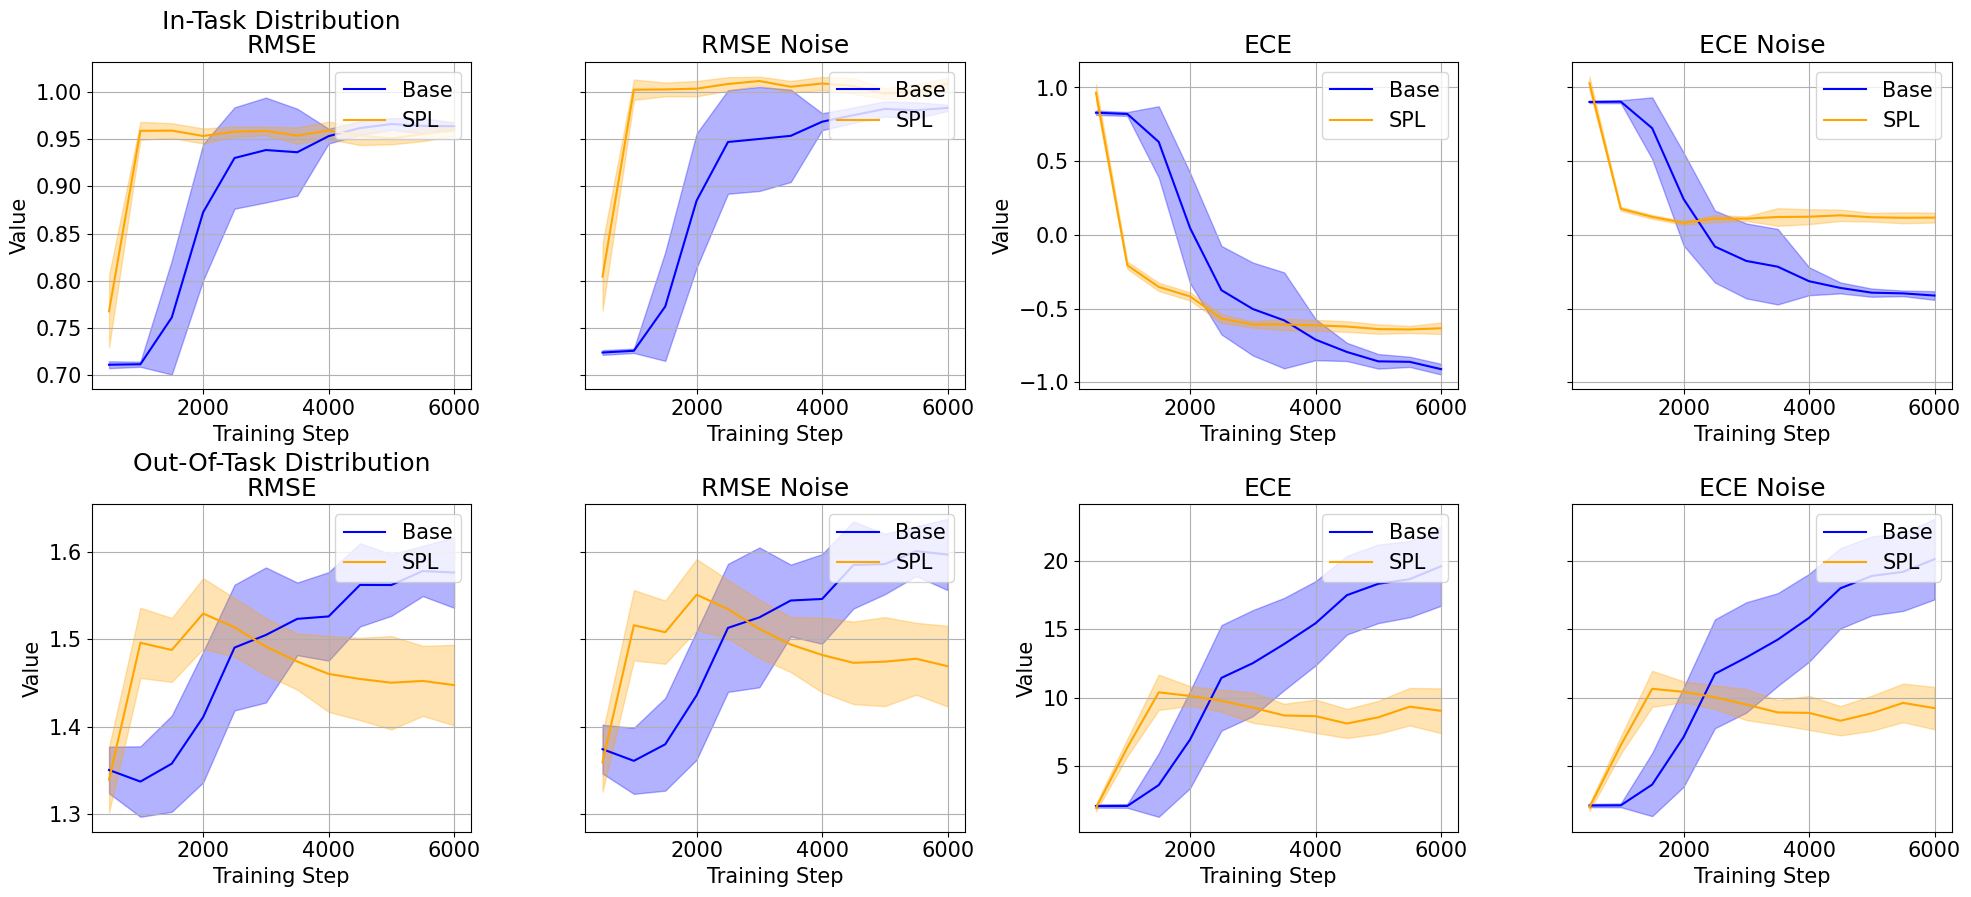

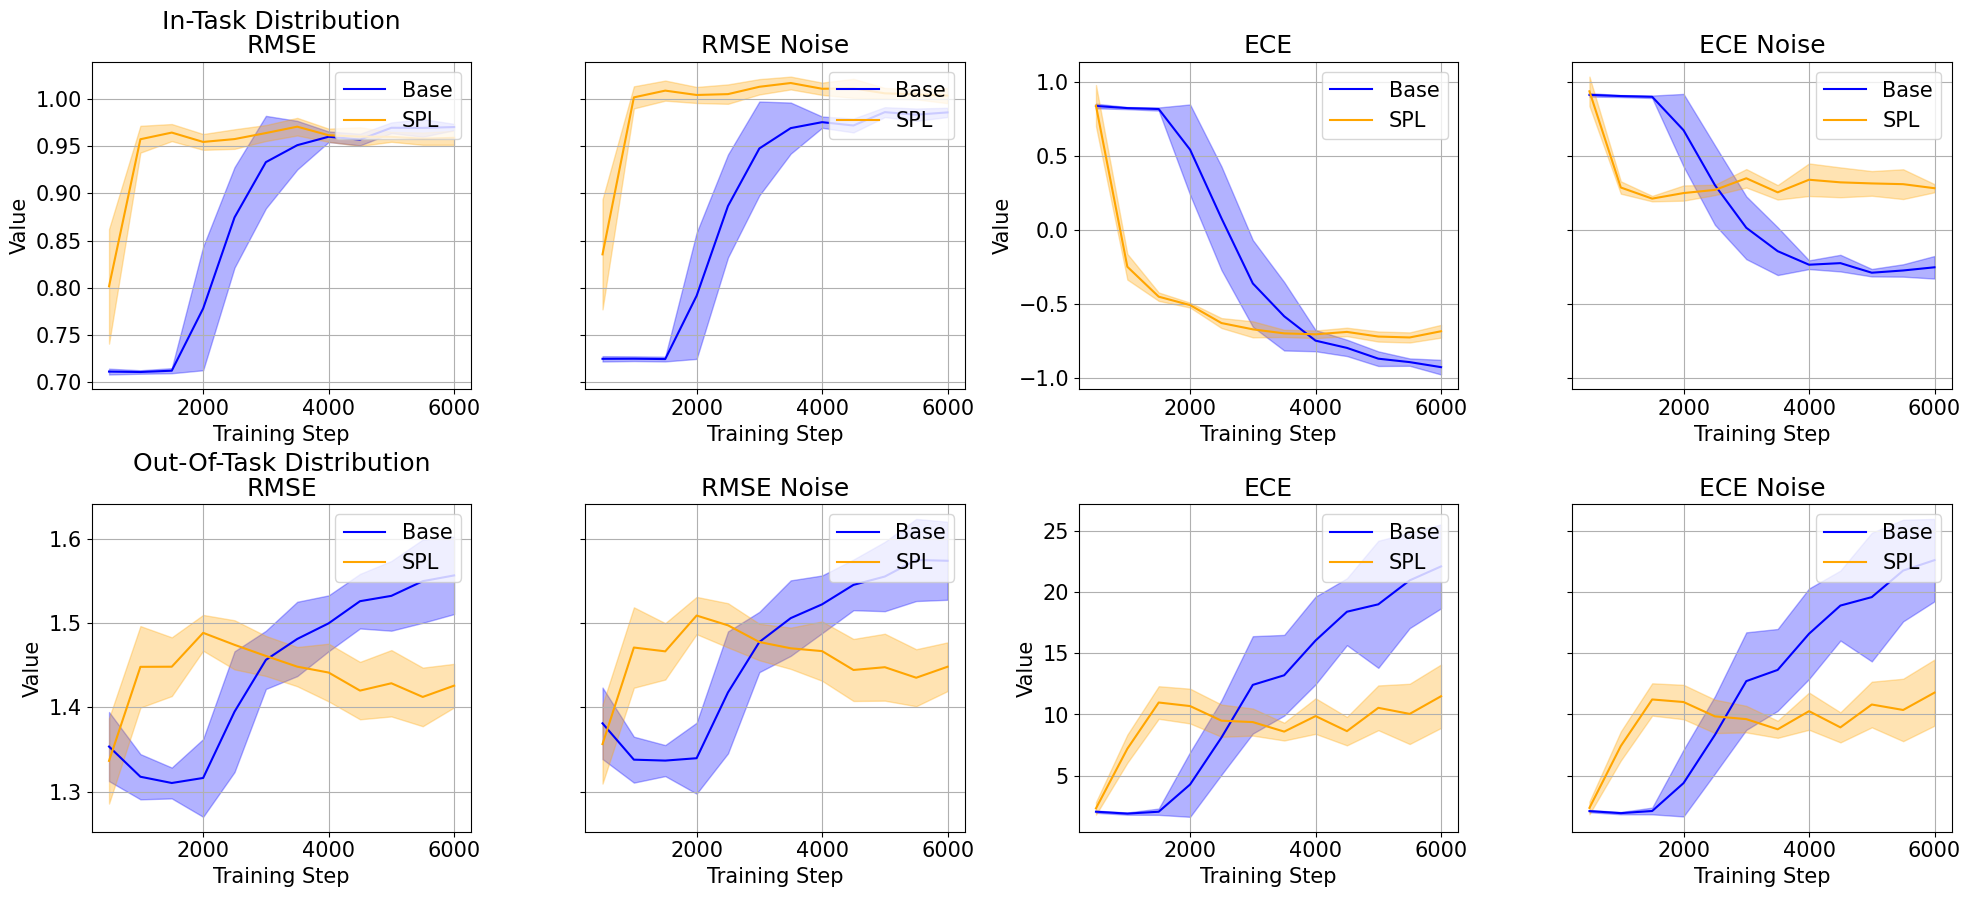

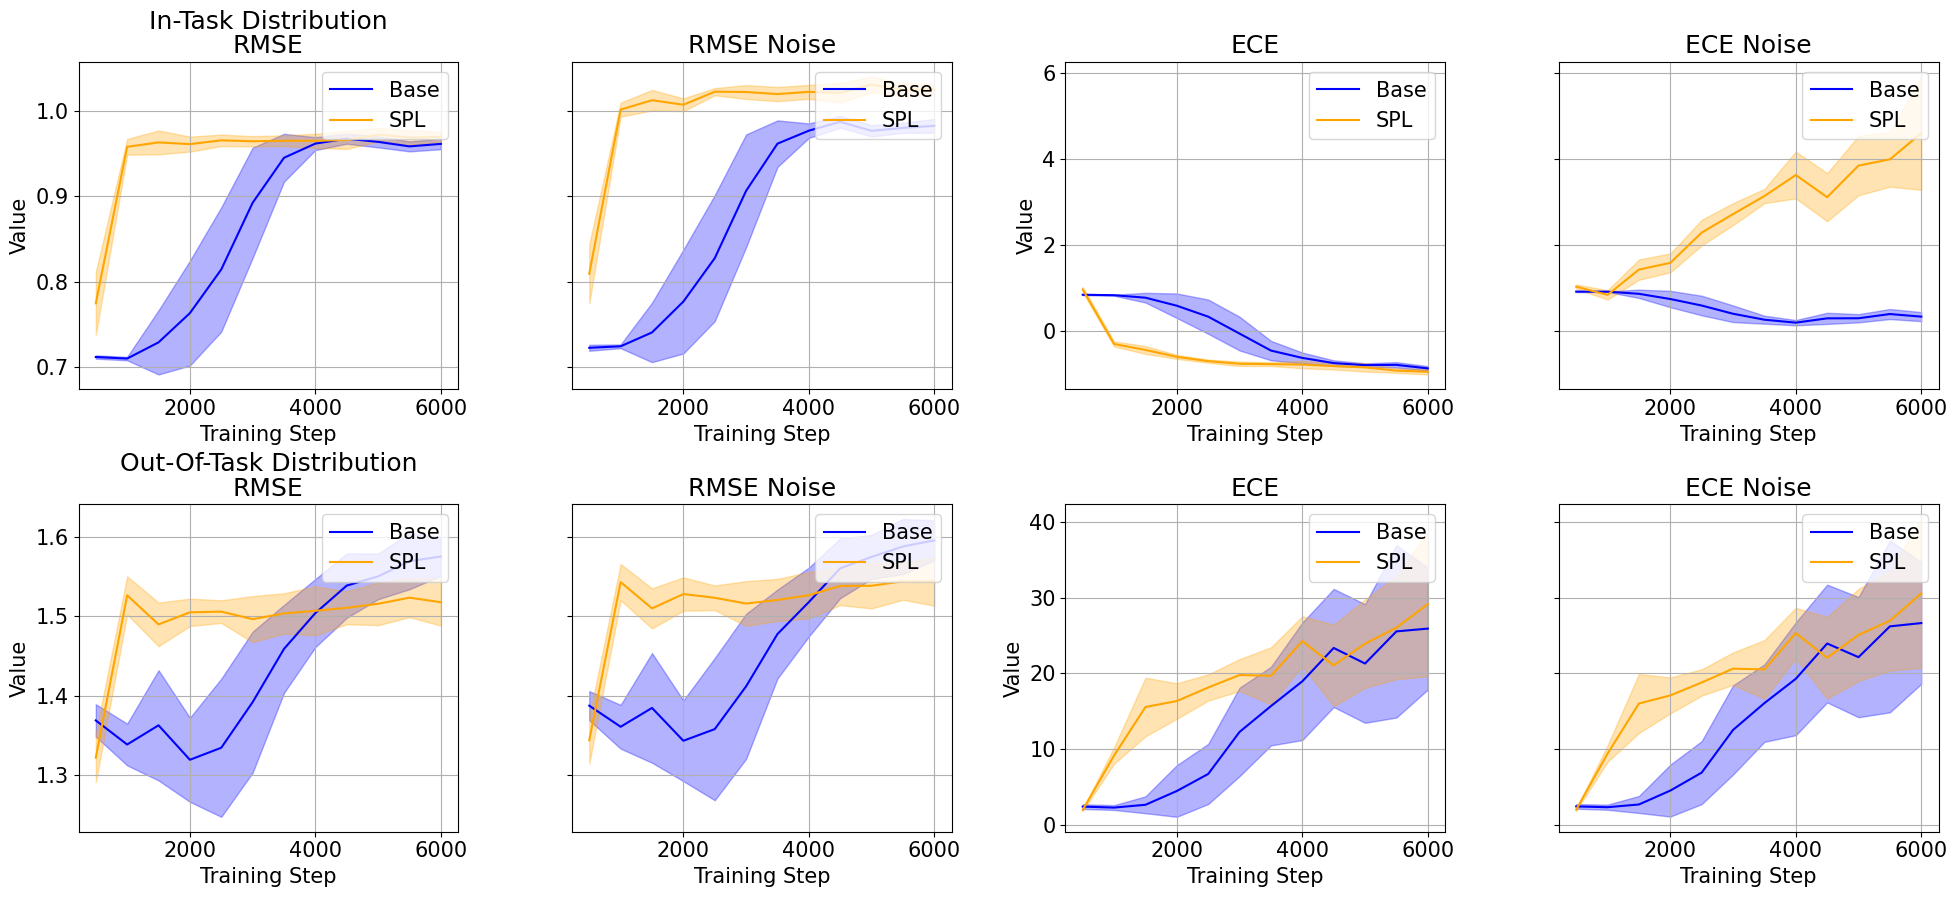

In [3]:
def comb_stds(mean, group_means, group_stds):
    # Calculate the combined standard deviation using the formula

    avg_stdscalc =sum([ (stdi**2 + (mi - mean)**2) for stdi,mi in zip(group_stds, group_means) ] )/len(group_means)

    return np.sqrt(avg_stdscalc)
# Function to separate means and stds
def separate_means_stds(metrics_dict):
    means = {}
    stds = {}
    for k, v in metrics_dict.items():
        mean_values = np.array([x[:, 0] for x in v])
        std_values = np.array([x[:, 1] for x in v])
        means[k] = mean_values
        stds[k] = std_values
    return means, stds

def calculate_confidence_interval(mean, std, n, confidence_level=0.95):
    t_score = t.ppf(1 - (1 - confidence_level) / 2, df=n - 1)
    margin_of_error = t_score * (std / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return lower_bound, upper_bound 


def plot_metrics(ax, metric, base_means, base_stds, spl_means, spl_stds, eval_period_length, n=10, confidence_level=0.95):
    x = [eval_period_length * (j + 1) for j in range(len(base_means))]

    # Calculate confidence intervals for base model
    base_lower, base_upper = calculate_confidence_interval(base_means, base_stds, n, confidence_level)

    # Calculate confidence intervals for SPL model
    spl_lower, spl_upper = calculate_confidence_interval(spl_means, spl_stds, n, confidence_level)

    # Plot base model
    ax.plot(x, base_means, label='Base', color='blue')
    ax.fill_between(x, base_lower, base_upper, color='blue', alpha=0.3)

    # Plot SPL model
    ax.plot([xi + 0.1 for xi in x], spl_means, label='SPL', color='orange')
    ax.fill_between([xi + 0.1 for xi in x], spl_lower, spl_upper, color='orange', alpha=0.3)

    ax.set_title(metric)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.legend(loc='upper right')


def plot_combined_metrics(base_in_means, base_in_stds, spl_in_means, spl_in_stds,
                          base_out_means, base_out_stds, spl_out_means, spl_out_stds,
                          noise_level):
    fig, axs = plt.subplots(2, 4, figsize=(24, 10), gridspec_kw={'hspace': 0.35, 'wspace': 0.3}) 

    eval_period_length = 500

  # In-task metrics
    plot_metrics(axs[0, 0], 'RMSE', base_in_means['rmse'], base_in_stds['rmse'], spl_in_means['rmse'], spl_in_stds['rmse'], eval_period_length)
    plot_metrics(axs[0, 1], 'RMSE Noise', base_in_means['rmse_noise'], base_in_stds['rmse_noise'], spl_in_means['rmse_noise'], spl_in_stds['rmse_noise'], eval_period_length)
    plot_metrics(axs[0, 2], 'ECE', base_in_means['ece'], base_in_stds['ece'], spl_in_means['ece'], spl_in_stds['ece'], eval_period_length)
    plot_metrics(axs[0, 3], 'ECE Noise', base_in_means['ece_noise'], base_in_stds['ece_noise'], spl_in_means['ece_noise'], spl_in_stds['ece_noise'], eval_period_length)

    # Out-of-task metrics
    plot_metrics(axs[1, 0], 'RMSE', base_out_means['rmse'], base_out_stds['rmse'], spl_out_means['rmse'], spl_out_stds['rmse'], eval_period_length)
    plot_metrics(axs[1, 1], 'RMSE Noise', base_out_means['rmse_noise'], base_out_stds['rmse_noise'], spl_out_means['rmse_noise'], spl_out_stds['rmse_noise'], eval_period_length)
    plot_metrics(axs[1, 2], 'ECE', base_out_means['ece'], base_out_stds['ece'], spl_out_means['ece'], spl_out_stds['ece'], eval_period_length)
    plot_metrics(axs[1, 3], 'ECE Noise', base_out_means['ece_noise'], base_out_stds['ece_noise'], spl_out_means['ece_noise'], spl_out_stds['ece_noise'], eval_period_length)

    # Share y-axis for RMSE/RMSE Noise and ECE/ECE Noise
    for row in axs:
        row[0].sharey(row[1])
        row[2].sharey(row[3]) 

# Hide y-tick labels for shared axes except for the leftmost ones
    for ax in [axs[0, 1], axs[1, 1]]:
        plt.setp(ax.get_yticklabels(), visible=False)
    for ax in [axs[0, 3], axs[1, 3]]:
        plt.setp(ax.get_yticklabels(), visible=False)
    # Add subtitles
     # Remove y-axis labels for shared axes
    for ax in [axs[0, 1], axs[1, 1], axs[0, 3], axs[1, 3]]:
        ax.set_ylabel('')

    axs[0, 0].annotate('In-Task Distribution', xy=(0.5, 1.1), xycoords='axes fraction', ha='center', fontsize=18)
    axs[1, 0].annotate('Out-Of-Task Distribution', xy=(0.5, 1.1), xycoords='axes fraction', ha='center', fontsize=18)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'aggregated_metrics_{noise_level}.png')

experiment_directory = "exp_ds_10runs"

plt.rcParams.update({'font.size': 15})
# Get the list of noise setup directories
noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]

# Define the number of noise setups
num_noise_setups = len(noise_setup_directories)

# Iterate over each noise setup directory
for i, noise_setup_directory in enumerate(noise_setup_directories):
    # Extract noise levels from directory name
    noise_levels = noise_setup_directory.split("_")[1:-1]

    # Initialize lists to store metrics for each model
    base_in_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}
    spl_in_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}

    base_out_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}
    spl_out_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}

    # Get the list of files in the noise setup directory
    saved_files = os.listdir(os.path.join(experiment_directory, noise_setup_directory))

    for file in saved_files:
        if file.endswith("_training_metrics.pkl"):
            model_name, _, _, _, _, _ = file.split("_")
            # Load the metrics from the file
            with open(os.path.join(experiment_directory, noise_setup_directory, file), "rb") as f:
                metrics = pickle.load(f)
            
            # Append metrics to the corresponding model's list

            if model_name == "base":
                base_in_metrics["rmse"].append(metrics["training_intask_errors"]["rmse"])
                base_in_metrics["ece"].append(metrics["training_intask_errors"]["ece"])
                base_in_metrics["rmse_noise"].append(metrics["training_intask_errors"]["rmse_noise"])
                base_in_metrics["ece_noise"].append(metrics["training_intask_errors"]["ece_noise"])

                base_out_metrics["rmse"].append(metrics["training_outtask_errors"]["rmse"]) 
                base_out_metrics["ece"].append(metrics["training_outtask_errors"]["ece"])
                base_out_metrics["rmse_noise"].append(metrics["training_outtask_errors"]["rmse_noise"])
                base_out_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])
            else:
                spl_in_metrics["rmse"].append(metrics["training_intask_errors"]["rmse"])
                spl_in_metrics["ece"].append(metrics["training_intask_errors"]["ece"])
                spl_in_metrics["rmse_noise"].append(metrics["training_intask_errors"]["rmse_noise"])
                spl_in_metrics["ece_noise"].append(metrics["training_intask_errors"]["ece_noise"])

                spl_out_metrics["rmse"].append(metrics["training_outtask_errors"]["rmse"])
                spl_out_metrics["ece"].append(metrics["training_outtask_errors"]["ece"])
                spl_out_metrics["rmse_noise"].append(metrics["training_outtask_errors"]["rmse_noise"])
                spl_out_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])
    

    # Convert the lists to numpy arrays
    
    base_in_metrics = {k: np.array(v) for k, v in base_in_metrics.items()}

    spl_in_metrics = {k: np.array(v) for k, v in spl_in_metrics.items()}

    base_out_metrics = {k: np.array(v) for k, v in base_out_metrics.items()}

    spl_out_metrics = {k: np.array(v) for k, v in spl_out_metrics.items()}

    # Lets aggregate over the runs now lets write it first for base_in_metrics


      # Separate the means and stds for base_in_metrics
    base_in_means, base_in_stds = separate_means_stds(base_in_metrics)
    base_out_means, base_out_stds = separate_means_stds(base_out_metrics)
    spl_in_means, spl_in_stds = separate_means_stds(spl_in_metrics)
    spl_out_means, spl_out_stds = separate_means_stds(spl_out_metrics)

    aggregated_base_in_means = {k: v.mean(axis=0) for k, v in base_in_means.items()} 
    aggregated_base_in_stds = {k: v.std(axis=0) for k, v in base_in_means.items()}
    print([aggregated_base_in_stds[k].shape for k in base_in_means.keys()])

    # Aggregate the means for base_out_metrics
    aggregated_base_out_means = {k: v.mean(axis=0) for k, v in base_out_means.items()}

    # Aggregate the stds for base_out_metrics
    aggregated_base_out_stds = {k: v.std(axis=0) for k, v in base_out_means.items()}


    # Aggregate the means for spl_out_metrics
    aggregated_spl_out_means = {k: v.mean(axis=0) for k, v in spl_out_means.items()}

    # Aggregate the stds for spl_out_metrics
    aggregated_spl_out_stds = {k: v.std(axis=0) for k, v in spl_out_means.items()}


    # Aggregate the means for spl_in_metrics
    aggregated_spl_in_means = {k: v.mean(axis=0) for k, v in spl_in_means.items()}

    aggregated_spl_in_stds = {k: v.std(axis=0) for k, v in spl_in_means.items()}
    
    # Aggregate the means for spl_out_metrics
    aggregated_spl_out_means = {k: v.mean(axis=0) for k, v in spl_out_means.items()}

    # Aggregate the stds for spl_out_metrics
    aggregated_spl_out_stds = {k: v.std(axis=0) for k, v in spl_out_means.items()}


    # Aggregate the means for spl_in_metrics
    aggregated_spl_in_means = {k: v.mean(axis=0) for k, v in spl_in_means.items()}

    # Aggregate the stds for spl_in_metrics
    aggregated_spl_in_stds = {k: v.std(axis=0) for k, v in spl_in_means.items()}
    

    plot_combined_metrics(aggregated_base_in_means, aggregated_base_in_stds, aggregated_spl_in_means, aggregated_spl_in_stds,
                            aggregated_base_out_means, aggregated_base_out_stds, aggregated_spl_out_means, aggregated_spl_out_stds,
                            noise_levels[0] + " - " + noise_levels[1])
    

/tmp/ipykernel_16429/1704490229.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


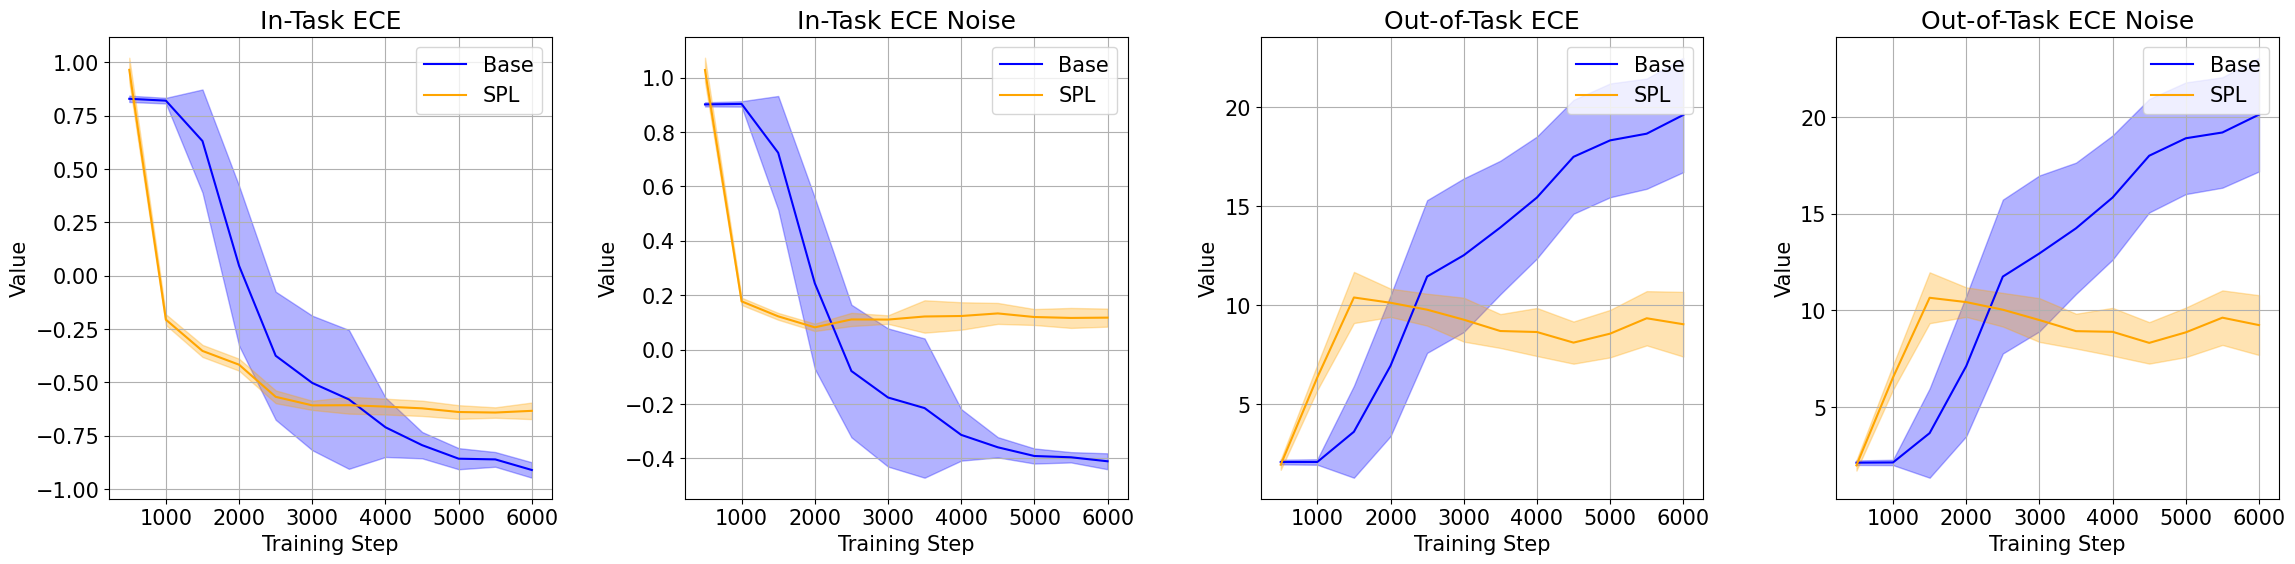

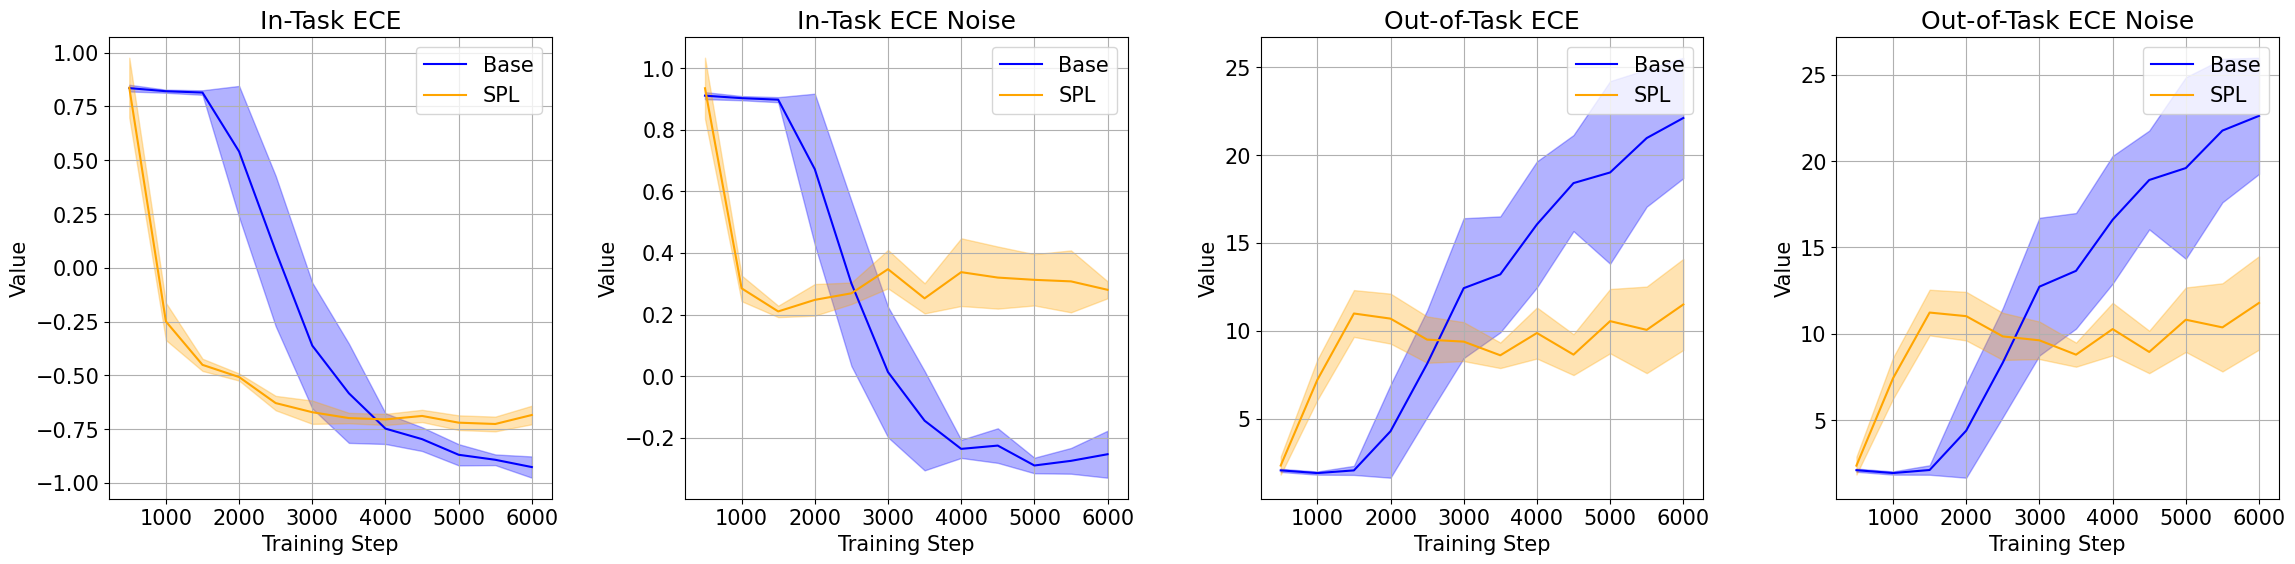

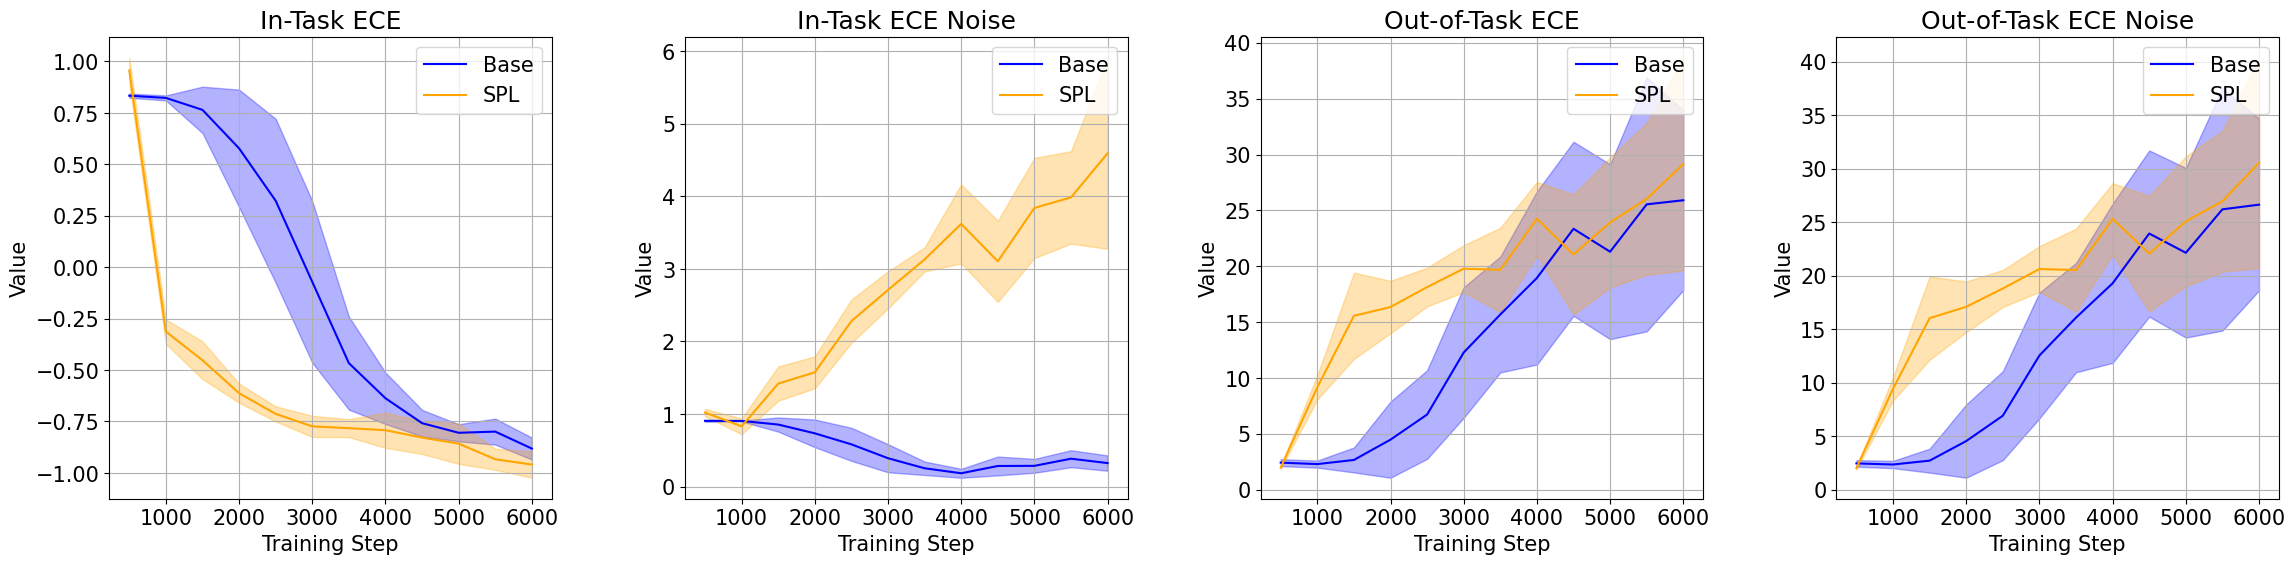

In [7]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

def separate_means_stds(metrics_dict):
    means = {}
    stds = {}
    for k, v in metrics_dict.items():
        mean_values = np.array([x[:, 0] for x in v])
        std_values = np.array([x[:, 1] for x in v])
        means[k] = mean_values
        stds[k] = std_values
    return means, stds

def calculate_confidence_interval(mean, std, n, confidence_level=0.95):
    t_score = t.ppf(1 - (1 - confidence_level) / 2, df=n - 1)
    margin_of_error = t_score * (std / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return lower_bound, upper_bound 

def plot_metrics(ax, metric, base_means, base_stds, spl_means, spl_stds, eval_period_length, n=10, confidence_level=0.95):
    x = [eval_period_length * (j + 1) for j in range(len(base_means))]

    # Calculate confidence intervals for base model
    base_lower, base_upper = calculate_confidence_interval(base_means, base_stds, n, confidence_level)

    # Calculate confidence intervals for SPL model
    spl_lower, spl_upper = calculate_confidence_interval(spl_means, spl_stds, n, confidence_level)

    # Plot base model
    ax.plot(x, base_means, label='Base', color='blue')
    ax.fill_between(x, base_lower, base_upper, color='blue', alpha=0.3)

    # Plot SPL model
    ax.plot([xi + 0.1 for xi in x], spl_means, label='SPL', color='orange')
    ax.fill_between([xi + 0.1 for xi in x], spl_lower, spl_upper, color='orange', alpha=0.3)

    ax.set_title(metric)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.legend(loc='upper right')

def plot_combined_metrics(base_in_means, base_in_stds, spl_in_means, spl_in_stds,
                          base_out_means, base_out_stds, spl_out_means, spl_out_stds,
                          noise_level):
    fig, axs = plt.subplots(1, 4, figsize=(28, 6), gridspec_kw={'wspace': 0.3}) 

    eval_period_length = 500

    # In-task metrics
    plot_metrics(axs[0], 'In-Task ECE', base_in_means['ece'], base_in_stds['ece'], spl_in_means['ece'], spl_in_stds['ece'], eval_period_length)
    plot_metrics(axs[1], 'In-Task ECE Noise', base_in_means['ece_noise'], base_in_stds['ece_noise'], spl_in_means['ece_noise'], spl_in_stds['ece_noise'], eval_period_length)

    # Out-of-task metrics
    plot_metrics(axs[2], 'Out-of-Task ECE', base_out_means['ece'], base_out_stds['ece'], spl_out_means['ece'], spl_out_stds['ece'], eval_period_length)
    plot_metrics(axs[3], 'Out-of-Task ECE Noise', base_out_means['ece_noise'], base_out_stds['ece_noise'], spl_out_means['ece_noise'], spl_out_stds['ece_noise'], eval_period_length)

    plt.tight_layout()
    plt.savefig(f'aggregated_metrics_{noise_level}.png')

experiment_directory = "exp_ds_10runs"

plt.rcParams.update({'font.size': 15})
# Get the list of noise setup directories
noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]

# Define the number of noise setups
num_noise_setups = len(noise_setup_directories)

# Iterate over each noise setup directory
for i, noise_setup_directory in enumerate(noise_setup_directories):
    # Extract noise levels from directory name
    noise_levels = noise_setup_directory.split("_")[1:-1]

    # Initialize lists to store metrics for each model
    base_in_metrics = {"ece": [], "ece_noise": []}
    spl_in_metrics = {"ece": [], "ece_noise": []}

    base_out_metrics = {"ece": [], "ece_noise": []}
    spl_out_metrics = {"ece": [], "ece_noise": []}

    # Get the list of files in the noise setup directory
    saved_files = os.listdir(os.path.join(experiment_directory, noise_setup_directory))

    for file in saved_files:
        if file.endswith("_training_metrics.pkl"):
            model_name, _, _, _, _, _ = file.split("_")
            # Load the metrics from the file
            with open(os.path.join(experiment_directory, noise_setup_directory, file), "rb") as f:
                metrics = pickle.load(f)
            
            # Append metrics to the corresponding model's list
            if model_name == "base":
                base_in_metrics["ece"].append(metrics["training_intask_errors"]["ece"])
                base_in_metrics["ece_noise"].append(metrics["training_intask_errors"]["ece_noise"])

                base_out_metrics["ece"].append(metrics["training_outtask_errors"]["ece"])
                base_out_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])
            else:
                spl_in_metrics["ece"].append(metrics["training_intask_errors"]["ece"])
                spl_in_metrics["ece_noise"].append(metrics["training_intask_errors"]["ece_noise"])

                spl_out_metrics["ece"].append(metrics["training_outtask_errors"]["ece"])
                spl_out_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])

    # Convert the lists to numpy arrays
    base_in_metrics = {k: np.array(v) for k, v in base_in_metrics.items()}
    spl_in_metrics = {k: np.array(v) for k, v in spl_in_metrics.items()}
    base_out_metrics = {k: np.array(v) for k, v in base_out_metrics.items()}
    spl_out_metrics = {k: np.array(v) for k, v in spl_out_metrics.items()}

    # Aggregate means and stds
    base_in_means, base_in_stds = separate_means_stds(base_in_metrics)
    spl_in_means, spl_in_stds = separate_means_stds(spl_in_metrics)
    base_out_means, base_out_stds = separate_means_stds(base_out_metrics)
    spl_out_means, spl_out_stds = separate_means_stds(spl_out_metrics)

    # Aggregate the means for each metric
    aggregated_base_in_means = {k: v.mean(axis=0) for k, v in base_in_means.items()}
    aggregated_base_in_stds = {k: v.std(axis=0) for k, v in base_in_means.items()}
    aggregated_spl_in_means = {k: v.mean(axis=0) for k, v in spl_in_means.items()}
    aggregated_spl_in_stds = {k: v.std(axis=0) for k, v in spl_in_means.items()}

    aggregated_base_out_means = {k: v.mean(axis=0) for k, v in base_out_means.items()}
    aggregated_base_out_stds = {k: v.std(axis=0) for k, v in base_out_means.items()}
    aggregated_spl_out_means = {k: v.mean(axis=0) for k, v in spl_out_means.items()}
    aggregated_spl_out_stds = {k: v.std(axis=0) for k, v in spl_out_means.items()}

    # Plot combined metrics
    plot_combined_metrics(aggregated_base_in_means, aggregated_base_in_stds, aggregated_spl_in_means, aggregated_spl_in_stds,
                          aggregated_base_out_means, aggregated_base_out_stds, aggregated_spl_out_means, aggregated_spl_out_stds,
                          noise_levels[0] + " - " + noise_levels[1])


base 20
base 25
base 23
base 27
spl 21
spl 23
spl 27
spl 24
spl 25
base 22
spl 29
base 21
base 26
spl 22
base 29
base 28
base 24
spl 26
spl 20
spl 28
10 10
spl 14
spl 15
base 17
spl 10
spl 16
base 14
base 15
base 16
base 10
base 12
base 19
spl 18
spl 13
base 13
spl 11
base 18
base 11
spl 12
spl 19
spl 17
10 10
base 4
spl 1
base 1
base 9
spl 6
spl 5
spl 8
spl 9
spl 4
base 5
spl 3
base 6
base 3
base 2
base 0
spl 0
spl 2
base 8
spl 7
base 7
10 10
                 Noise setup 0.6-0.4                                           \
                            No Noise                                            
                                base                                      spl   
                                rmse                   ece               rmse   
n      3           0.62 (0.62, 0.63)   10.08 (9.34, 10.82)  0.59 (0.58, 0.59)   
       4           0.75 (0.74, 0.76)  12.46 (11.46, 13.46)  0.71 (0.70, 0.71)   
amp    1.0         0.16 (0.15, 0.17)  -0.23 (-0.34, -0.12)  0.17 (

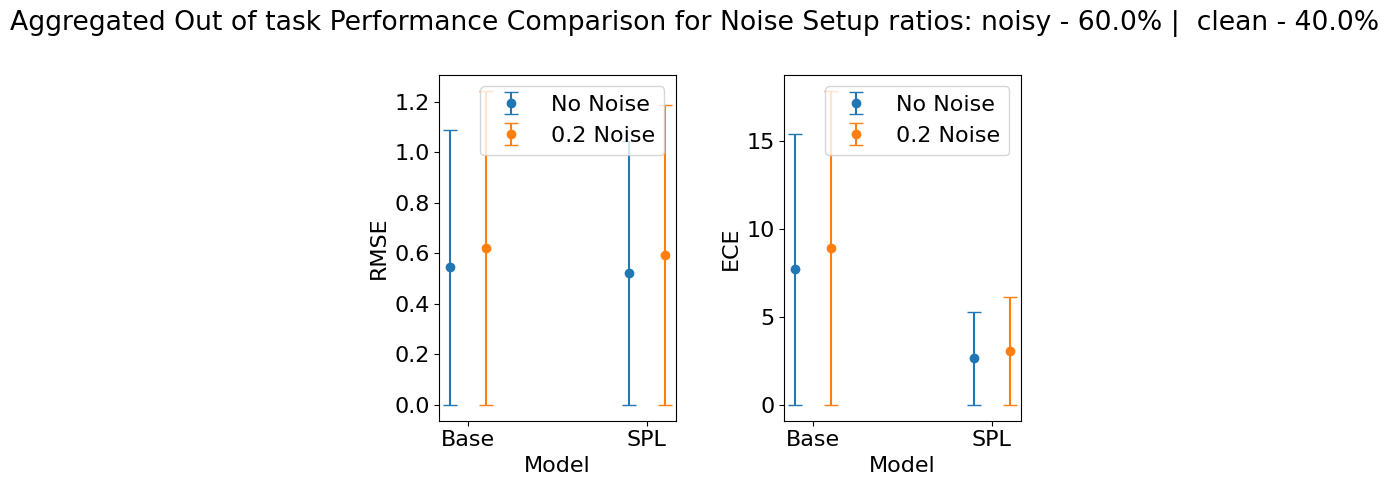

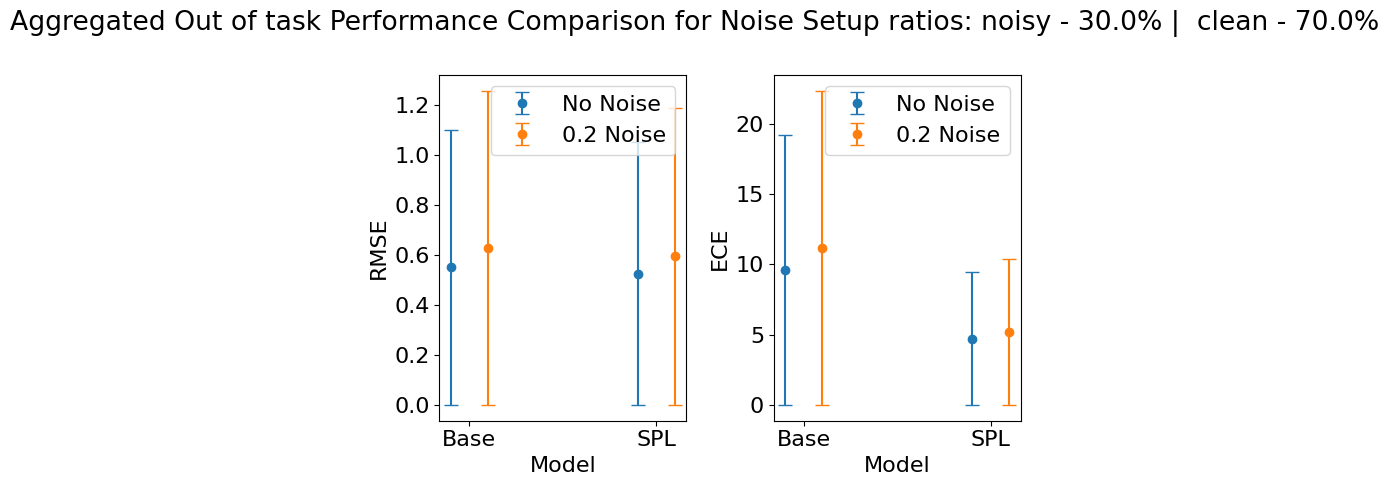

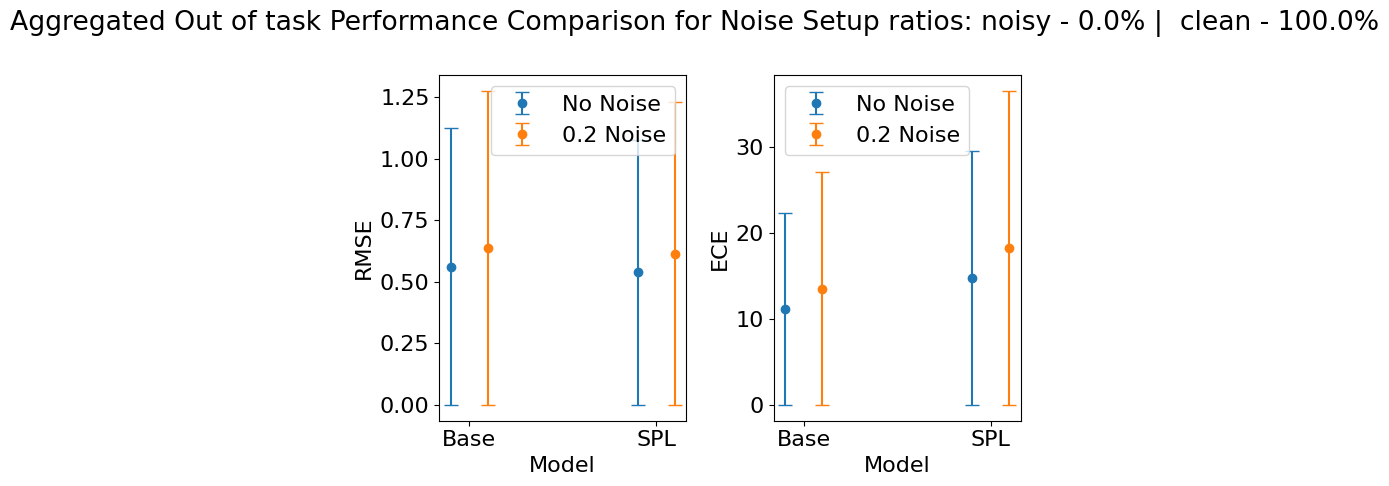

In [9]:
from spl_training_script import cross_entropy_error, RMSE_means
import re
from aa_train_utils.model_utils import create_model
from aa_train_utils.dataset_generation import generate_dataset, joint, uniform


# Now lets define a function, that will take a model, a sampler, and a test_dataset_size and calculates the performance metrics on them . 
# So we can provide the same key , for the different models, and we can provide different keys over  the models from different runs. 
def calc_metrics_on_sampler(sampler, test_size, model, params, num_posterior_mc, chunk_size, num_context_samples, eval_key):
    # Use chunking
    eval_key_data , eval_model_key = jax.random.split(eval_key)

    x_eval, y_eval = generate_dataset(eval_key_data, test_size, sampler, chunk_size=chunk_size)
    x_eval, y_eval = x_eval[..., None], y_eval[..., None]

    #lets split them into the context and target sets
    x_contexts, x_targets = jnp.split(x_eval, indices_or_sections=(num_context_samples, ), axis=1)
    y_contexts, y_targets = jnp.split(y_eval, indices_or_sections=(num_context_samples, ), axis=1)

    ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, test_size))
    rmse_errors= nk.jax.vmap_chunked(partial(RMSE_means, model, params, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, test_size))

    return ece_errors.mean(), rmse_errors.mean()
def make_sampler(f, points, range):
    return partial(joint, f, partial(uniform, n=points, bounds=(range[0], range[1])))

test_size =128*100
num_posterior_mc = 1
chunk_size =128*10
num_context_samples = 64
num_target_samples = 32

# Lets also setup the distributions for the out of task distribution evaluations. 

# First lets define all the samplers we will be using to create the data. 

# The in task distribution we will be changing the parameters of one by one
f2 = Fourier(n=2, amplitude=.5, period=1.0 , period_range=0.2)
 

#The resulting out of task distributions. 
n_3 = Fourier(n=3, amplitude=0.5, period=1.0, period_range=0.2)
n_4 = Fourier(n=4, amplitude=0.5, period=1.0, period_range=0.2)

amp_1 = Fourier(n=2, amplitude=1.0, period=1.0, period_range=0.2)
amp_2 = Fourier(n=2, amplitude=2.0, period=1.0, period_range=0.2)

per_1_05 = Fourier(n=2, amplitude=0.5, period=1.0, period_range=0.5)
per_15_05 = Fourier(n=2, amplitude=0.5, period=1.5, period_range=0.5)

# Now with the different noise levels we will be using the same functions but with different noise levels.

n_3_noise = WhiteNoise(n_3, 0.2)
n_4_noise = WhiteNoise(n_4, 0.2)

amp_1_noise = WhiteNoise(amp_1, 0.2)
amp_2_noise = WhiteNoise(amp_2, 0.2)

per_1_05_noise = WhiteNoise(per_1_05, 0.2)
per_15_05_noise = WhiteNoise(per_15_05, 0.2)


# Create a dictionary to store the samplers
samplers = {
    'n_3': n_3,
    'n_4': n_4,
    'amp_1.0': amp_1,
    'amp_2.0': amp_2,
    'period_(1.0,0.5)': per_1_05,
    'period_(1.5,0.5)': per_15_05,
    'n_3_noise': n_3_noise,
    'n_4_noise': n_4_noise,
    'amp_1.0_noise': amp_1_noise,
    'amp_2.0_noise': amp_2_noise,
    'period_(1.0,0.5)_noise': per_1_05_noise,
    'period_(1.5,0.5)_noise': per_15_05_noise
}


samplers = {k: make_sampler(v, num_context_samples+num_target_samples, (-1.0, 1.0)) for k, v in samplers.items()}






experiment_directory = "exp_ds_10runs"

# Get the list of noise setup directories

noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]

# Define the number of noise setups
num_noise_setups = len(noise_setup_directories)

row_index_values = pd.MultiIndex.from_tuples([(k.split("_")[0],k.split("_")[1]) for k in samplers.keys() if "noise" not in k])
# Lets construct the indeces for the columns
noise_setups = ["Noise setup "+"-".join(d.split("_")[1:-1]) for d in noise_setup_directories]


columns = pd.MultiIndex.from_product([noise_setups, ["No Noise", "0.2 Noise"], ["base", "spl"],["rmse", "ece"]])
plt.rcParams.update({'font.size': 16})
eval_table_df = pd.DataFrame(index=row_index_values, columns=columns)
# Iterate over each noise setup directory
for i, noise_setup_directory in enumerate(noise_setup_directories):
    # Extract noise levels from directory name
    noise_levels = noise_setup_directory.split("_")[1:-1]

    # Get the list of files in the noise setup directory
    saved_files = os.listdir(os.path.join(experiment_directory, noise_setup_directory))

    # Get the list of files in the directory

    # Regular expression to match the files with any word, followed by either integers or floats separated by underscores, and ending with .pkl
    pattern = re.compile(r'\w+_(\d+(\.\d+)?)_(\d+(\.\d+)?)_(\d+(\.\d+)?)\.pkl')

    # Filter the files based on the regular expression
    filtered_files = [f for f in saved_files if pattern.match(f)]

    
    base_metric_dics= []
    spl_metric_dics=[]
    for file in filtered_files:
        model_name, _, _, run_seed = file.split("_")
        run_seed = int(run_seed.split(".")[0])
        # Load the metrics from the file
        with open(os.path.join(experiment_directory, noise_setup_directory, file), "rb") as f:
            model_params = pickle.load(f)
        
        print(model_name, run_seed)
        # Lets use the run_seed to initialite the model again , but it doesnt mather since the params will be replaced anyway.

        model, junk_params = create_model(jax.random.PRNGKey(int(run_seed)))
        params = model_params

        model_persampler_metrics = {k : {"rmse": [], "ece":[]} for k in samplers.keys()} 

        for sampler_key, sampler in samplers.items():
            ece_error, rmse_error = calc_metrics_on_sampler(sampler, test_size, model, params, num_posterior_mc, chunk_size, num_context_samples, jax.random.PRNGKey(int(run_seed)))
            model_persampler_metrics[sampler_key]["rmse"].append(rmse_error)
            model_persampler_metrics[sampler_key]["ece"].append(ece_error)

        if model_name == "base":
            base_metric_dics.append(model_persampler_metrics)
        else:
            spl_metric_dics.append(model_persampler_metrics) 

    # After we are done calculating the metrics for each model and run. we can get the mean and confidence intervals for each evaluation setup.
    base_means = {k: {m: np.mean([d[k][m] for d in base_metric_dics], axis=0) for m in ["rmse", "ece"]} for k in samplers.keys()} 
    base_std = {k: {m: np.std([d[k][m] for d in base_metric_dics], axis=0) for m in ["rmse", "ece"]} for k in samplers.keys()}
    spl_means = {k: {m: np.mean([d[k][m] for d in spl_metric_dics], axis=0) for m in ["rmse", "ece"]} for k in samplers.keys()}
    spl_std = {k: {m: np.std([d[k][m] for d in spl_metric_dics], axis=0) for m in ["rmse", "ece"]} for k in samplers.keys()}


    # Calculating means across samplers per run. 
    # Calculate the mean value for each run across all samplers for noisy and non-noisy samplers
    base_mean_values_noisy = {
        metric: np.mean([metrics_dict[sampler_key][metric] for metrics_dict in base_metric_dics 
                        for sampler_key in metrics_dict if "noise" in sampler_key])
        for metric in ['rmse', 'ece']
    }

    base_mean_value_clean = {
        metric: np.mean([metrics_dict[sampler_key][metric] for metrics_dict in base_metric_dics
                        for sampler_key in metrics_dict if "noise" not in sampler_key])
        for metric in ['rmse', 'ece']
    }

    spl_mean_values_noisy = {
        metric: np.mean([metrics_dict[sampler_key][metric] for metrics_dict in spl_metric_dics
                        for sampler_key in metrics_dict if "noise" in sampler_key])
        for metric in ['rmse', 'ece']
    }

    spl_mean_value_clean = {
        metric: np.mean([metrics_dict[sampler_key][metric] for metrics_dict in spl_metric_dics
                        for sampler_key in metrics_dict if "noise" not in sampler_key])
        for metric in ['rmse', 'ece']
    }
    # Calculate the standard deviation for each run across all samplers for noisy and non-noisy samplers
    base_std_values_noisy = {
        metric: np.std(base_mean_values_noisy[metric])
        for metric in ['rmse', 'ece']
    }

    base_std_value_clean = {
        metric: np.std(base_mean_value_clean[metric])
        for metric in ['rmse', 'ece']
    }

    spl_std_values_noisy = {
        metric: np.std(spl_mean_values_noisy[metric])
        for metric in ['rmse', 'ece']
    }

    spl_std_value_clean = {
        metric: np.std(spl_mean_value_clean[metric])
        for metric in ['rmse', 'ece']
    }

    # Calculate the confidence intervals for each run across all samplers for noisy and non-noisy samplers
    print(len(base_metric_dics) , len(spl_metric_dics))
    base_confidence_intervals_noisy = {
        metric: calculate_confidence_interval(base_mean_values_noisy[metric], base_std_values_noisy[metric], len(base_metric_dics), 0.95)
        for metric in ['rmse', 'ece']
    }

    base_confidence_intervals_clean = {
        metric: calculate_confidence_interval(base_mean_value_clean[metric], base_std_value_clean[metric], len(base_metric_dics), 0.95)
        for metric in ['rmse', 'ece']
    }

    spl_confidence_intervals_noisy = {
        metric: calculate_confidence_interval(spl_mean_values_noisy[metric], spl_std_values_noisy[metric], len(spl_metric_dics), 0.95)
        for metric in ['rmse', 'ece']
    }

    spl_confidence_intervals_clean = {
        metric: calculate_confidence_interval(spl_mean_value_clean[metric], spl_std_value_clean[metric], len(spl_metric_dics), 0.95)
        for metric in ['rmse', 'ece']
    }

        # Define the labels and data
    
    # Define the labels and data
    labels = ['Base', 'SPL']
    clean_rmse_means = [base_mean_value_clean['rmse'], spl_mean_value_clean['rmse']]
    noisy_rmse_means = [base_mean_values_noisy['rmse'], spl_mean_values_noisy['rmse']]
    clean_ece_means = [base_mean_value_clean['ece'], spl_mean_value_clean['ece']]
    noisy_ece_means = [base_mean_values_noisy['ece'], spl_mean_values_noisy['ece']]
    clean_rmse_cis = [base_confidence_intervals_clean['rmse'][0], spl_confidence_intervals_clean['rmse'][0]]
    noisy_rmse_cis = [base_confidence_intervals_noisy['rmse'][0], spl_confidence_intervals_noisy['rmse'][0]]
    clean_ece_cis = [base_confidence_intervals_clean['ece'][0], spl_confidence_intervals_clean['ece'][0]]
    noisy_ece_cis = [base_confidence_intervals_noisy['ece'][0], spl_confidence_intervals_noisy['ece'][0]]

    

    # Plot RMSE and ECE in subplots
    fig, axs = plt.subplots(1, 2, figsize=(7, 5))

    # Plot RMSE subplot
    axs[0].errorbar(np.arange(len(labels))-0.1, clean_rmse_means, yerr=clean_rmse_cis, fmt='o', label='No Noise', capsize=5)
    axs[0].errorbar(np.arange(len(labels))+0.1, noisy_rmse_means, yerr=noisy_rmse_cis, fmt='o', label='0.2 Noise', capsize=5)
    axs[0].set_xticks(np.arange(len(labels)))
    axs[0].set_xticklabels(labels)
    axs[0].set_xlabel('Model')
    axs[0].set_ylabel('RMSE')
    axs[0].legend()

    # Plot ECE subplot
    axs[1].errorbar(np.arange(len(labels))-0.1, clean_ece_means, yerr=clean_ece_cis, fmt='o', label='No Noise', capsize=5)
    axs[1].errorbar(np.arange(len(labels))+0.1, noisy_ece_means, yerr=noisy_ece_cis, fmt='o', label='0.2 Noise', capsize=5)
    axs[1].set_xticks(np.arange(len(labels)))
    axs[1].set_xticklabels(labels)
    axs[1].set_xlabel('Model')
    axs[1].set_ylabel('ECE')
    axs[1].legend()

    # Convert noise levels to percentages

    fig.suptitle(f'Aggregated Out of task Performance Comparison for Noise Setup ratios: noisy - ' + str(float(noise_levels[0])*100.0) + "% | " + " clean - " + str(float(noise_levels[1])*100.0) + "%")
    plt.tight_layout()
    plt.savefig('performance_comparison'+str(i)+'.png')

    base_confidence_intervals = {k: {m: calculate_confidence_interval(base_means[k][m], base_std[k][m], len(base_metric_dics), 0.95) for m in ["rmse", "ece"]} for k in samplers.keys()}

    spl_confidence_intervals = {k: {m: calculate_confidence_interval(spl_means[k][m], spl_std[k][m], len(spl_metric_dics), 0.95) for m in ["rmse", "ece"]} for k in samplers.keys()}

    base_value_strings = {k: {m: f'{base_means[k][m][0]:.2f} ({base_confidence_intervals[k][m][0][0]:.2f}, {base_confidence_intervals[k][m][1][0]:.2f})' for m in ["rmse", "ece"]} for k in samplers.keys()}
    spl_value_strings = {k: {m: f'{spl_means[k][m][0]:.2f} ({spl_confidence_intervals[k][m][0][0]:.2f}, {spl_confidence_intervals[k][m][1][0]:.2f})' for m in ["rmse", "ece"]} for k in samplers.keys()}

    
    noise_setup = "Noise setup "+"-".join(noise_levels)

    for sampler_key in samplers.keys():
        for metric in ["rmse", "ece"]:

            if("noise" in sampler_key):

                eval_table_df.loc[(sampler_key.split("_")[0], sampler_key.split("_")[1]), (noise_setup, "0.2 Noise", "base", metric)] = base_value_strings[sampler_key][metric]
                eval_table_df.loc[(sampler_key.split("_")[0], sampler_key.split("_")[1]), (noise_setup, "0.2 Noise", "spl", metric)] = spl_value_strings[sampler_key][metric]
            else:
                eval_table_df.loc[(sampler_key.split("_")[0], sampler_key.split("_")[1]), (noise_setup, "No Noise", "base", metric)] = base_value_strings[sampler_key][metric]
                eval_table_df.loc[(sampler_key.split("_")[0], sampler_key.split("_")[1]), (noise_setup, "No Noise", "spl", metric)] = spl_value_strings[sampler_key][metric]


print(eval_table_df)

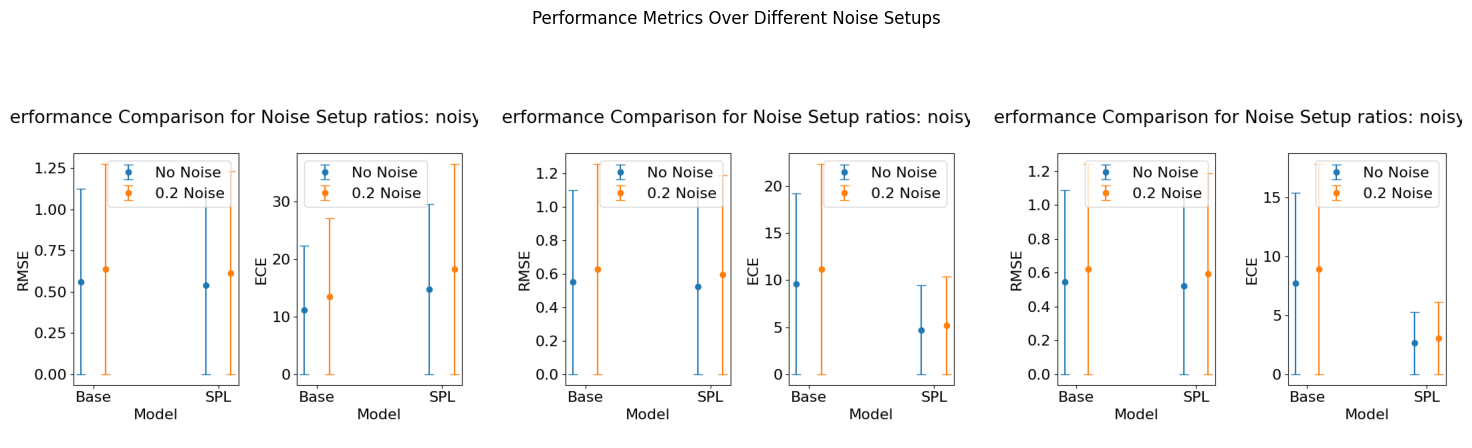

In [10]:
# Create a single figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Load the images from the previously saved files
img1 = plt.imread('performance_comparison2.png')
img2 = plt.imread('performance_comparison1.png')
img3 = plt.imread('performance_comparison0.png')

# Plot the images in the subplots
axs[0].imshow(img1)
axs[0].axis('off')  # Turn off axes for cleaner display
axs[1].imshow(img2)
axs[1].axis('off')
axs[2].imshow(img3)
axs[2].axis('off')

# Add a title to the larger figure
fig.suptitle('Performance Metrics Over Different Noise Setups', fontsize=12)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save or display the final figure
plt.savefig('merged_performance_metrics.png')

In [15]:
eval_table_df.T.index.rename(["Noise setup", "Noise level", "Model", "Metric"], inplace=True)
eval_table_df.T.columns.rename(["Param Type", "Param Value"], inplace=True)
eval_table_df.to_pickle('eval_table_df.pkl') 
print(eval_table_df.T.to_latex())

\begin{tabular}{llllllllll}
\toprule
 &  &  & Param Type & \multicolumn{2}{r}{n} & \multicolumn{2}{r}{amp} & \multicolumn{2}{r}{period} \\
 &  &  & Param Value & 3 & 4 & 1.0 & 2.0 & (1.0,0.5) & (1.5,0.5) \\
Noise setup & Noise level & Model & Metric &  &  &  &  &  &  \\
\midrule
\multirow[t]{8}{*}{Noise setup 0.6-0.4} & \multirow[t]{4}{*}{No Noise} & \multirow[t]{2}{*}{base} & rmse & 0.62 (0.62, 0.63) & 0.75 (0.74, 0.76) & 0.16 (0.15, 0.17) & 1.09 (1.06, 1.12) & 0.27 (0.27, 0.28) & 0.36 (0.35, 0.38) \\
 &  &  & ece & 10.08 (9.34, 10.82) & 12.46 (11.46, 13.46) & -0.23 (-0.34, -0.12) & 19.23 (15.59, 22.87) & 1.46 (1.30, 1.62) & 3.32 (2.83, 3.81) \\
\cline{3-10}
 &  & \multirow[t]{2}{*}{spl} & rmse & 0.59 (0.58, 0.59) & 0.71 (0.70, 0.71) & 0.17 (0.17, 0.18) & 1.07 (1.04, 1.10) & 0.28 (0.27, 0.28) & 0.32 (0.32, 0.32) \\
 &  &  & ece & 2.44 (2.21, 2.67) & 2.98 (2.69, 3.27) & -0.32 (-0.36, -0.27) & 9.94 (8.01, 11.88) & 0.28 (0.22, 0.33) & 0.62 (0.56, 0.69) \\
\cline{2-10} \cline{3-10}
 & \mu

In [2]:
from spl_training_script import cross_entropy_error, RMSE_means
import re
from aa_train_utils.model_utils import create_model
from aa_train_utils.dataset_generation import generate_dataset, joint, uniform


def calculate_confidence_interval(mean, std, n, confidence_level=0.95):
    t_score = t.ppf(1 - (1 - confidence_level) / 2, df=n - 1)
    margin_of_error = t_score * (std / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return lower_bound, upper_bound 

# Now lets define a function, that will take a model, a sampler, and a test_dataset_size and calculates the performance metrics on them . 
# So we can provide the same key , for the different models, and we can provide different keys over  the models from different runs. 
def calc_metrics_on_sampler(sampler, test_size, model, params, num_posterior_mc, chunk_size, num_context_samples, eval_key):
    # Use chunking
    eval_key_data , eval_model_key = jax.random.split(eval_key)

    x_eval, y_eval = generate_dataset(eval_key_data, test_size, sampler, chunk_size=chunk_size)
    x_eval, y_eval = x_eval[..., None], y_eval[..., None]

    #lets split them into the context and target sets
    x_contexts, x_targets = jnp.split(x_eval, indices_or_sections=(num_context_samples, ), axis=1)
    y_contexts, y_targets = jnp.split(y_eval, indices_or_sections=(num_context_samples, ), axis=1)

    ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, test_size))
    rmse_errors= nk.jax.vmap_chunked(partial(RMSE_means, model, params, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, test_size))

    return ece_errors.mean(), rmse_errors.mean()
def make_sampler(f, points, range):
    return partial(joint, f, partial(uniform, n=points, bounds=(range[0], range[1])))

test_size =128*100
num_posterior_mc = 1
chunk_size =128
num_context_samples = 64
num_target_samples = 32

# Lets also setup the distributions for the out of task distribution evaluations. 

# First lets define all the samplers we will be using to create the data. 

# The in task distribution we will be changing the parameters of one by one
f2 = Fourier(n=2, amplitude=.5, period=1.0 , period_range=0.2)
 

intask_00 = Fourier(n=2, amplitude=0.0, period=1.0, period_range=0.2)
intask_02 = WhiteNoise(Fourier(n=2, amplitude=0.2, period=1.0, period_range=0.2), 0.2)
intask_03 = WhiteNoise(Fourier(n=2, amplitude=0.2, period=1.0, period_range=0.2), 0.3)
intask_04 = WhiteNoise(Fourier(n=2, amplitude=0.2, period=1.0, period_range=0.2), 0.4)
intask_05 = WhiteNoise(Fourier(n=2, amplitude=0.2, period=1.0, period_range=0.2), 0.5)
intask_06 = WhiteNoise(Fourier(n=2, amplitude=0.2, period=1.0, period_range=0.2), 0.6)

# Create a dictionary to store the samplers

samplers = {
    "intask_0.0": intask_00, 
    "intask_0.2": intask_02, 
    "intask_0.3": intask_03,
    "intask_0.4": intask_04,
    "intask_0.5": intask_05,
    "intask_0.6": intask_06,
}


samplers = {k: make_sampler(v, num_context_samples+num_target_samples, (-1.0, 1.0)) for k, v in samplers.items()}






experiment_directory = "exp_ds_10runs"

# Get the list of noise setup directories

noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]

# Define the number of noise setups
num_noise_setups = len(noise_setup_directories)

# Create the row_index_values directly from sampler keys
row_index_values = ["metrics"]

# Lets construct the indeces for the columns
noise_setups = ["Noise setup "+"-".join(d.split("_")[1:-1]) for d in noise_setup_directories]


columns = pd.MultiIndex.from_product([noise_setups, ["0.0", "0.2", "0.3", "0.4", "0.5", "0.6"], ["base", "spl"],["rmse", "ece"]])

intask_eval_table_df = pd.DataFrame(index=row_index_values, columns=columns)
# Iterate over each noise setup directory
for i, noise_setup_directory in enumerate(noise_setup_directories):
    # Extract noise levels from directory name
    noise_levels = noise_setup_directory.split("_")[1:-1]

    # Get the list of files in the noise setup directory
    saved_files = os.listdir(os.path.join(experiment_directory, noise_setup_directory))

    # Get the list of files in the directory

    # Regular expression to match the files with any word, followed by either integers or floats separated by underscores, and ending with .pkl
    pattern = re.compile(r'\w+_(\d+(\.\d+)?)_(\d+(\.\d+)?)_(\d+(\.\d+)?)\.pkl')

    # Filter the files based on the regular expression
    filtered_files = [f for f in saved_files if pattern.match(f)]

    
    base_metric_dics= []
    spl_metric_dics=[]
    for file in filtered_files:
        model_name, _, _, run_seed = file.split("_")
        run_seed = int(run_seed.split(".")[0])
        # Load the metrics from the file
        with open(os.path.join(experiment_directory, noise_setup_directory, file), "rb") as f:
            model_params = pickle.load(f)
        
        print(model_name, run_seed)
        # Lets use the run_seed to initialite the model again , but it doesnt mather since the params will be replaced anyway.

        model, junk_params = create_model(jax.random.PRNGKey(int(run_seed)))
        params = model_params

        model_persampler_metrics = {k : {"rmse": [], "ece":[]} for k in samplers.keys()} 

        for sampler_key, sampler in samplers.items():
            ece_error, rmse_error = calc_metrics_on_sampler(sampler, test_size, model, params, num_posterior_mc, chunk_size, num_context_samples, jax.random.PRNGKey(int(run_seed)))
            model_persampler_metrics[sampler_key]["rmse"].append(rmse_error)
            model_persampler_metrics[sampler_key]["ece"].append(ece_error)

        if model_name == "base":
            base_metric_dics.append(model_persampler_metrics)
        else:
            spl_metric_dics.append(model_persampler_metrics) 
# Calculate mean and CI for each model and noise setup
    noise_setup_name = "Noise setup " + "-".join(noise_levels)
    for noise_level,sampler_key in zip(["0.0", "0.2", "0.3", "0.4", "0.5", "0.6"],samplers.keys()):

        for model_name, metric_dics in zip(["base", "spl"], [base_metric_dics, spl_metric_dics]):
            rmse_values = np.array([metrics[sampler_key]["rmse"] for metrics in metric_dics])
            ece_values = np.array([metrics[sampler_key]["ece"] for metrics in metric_dics])

            rmse_mean = rmse_values.mean()
            rmse_std = rmse_values.std()
            rmse_ci_lower, rmse_ci_upper = calculate_confidence_interval(rmse_mean, rmse_std, len(rmse_values))

            ece_mean = ece_values.mean()
            ece_std = ece_values.std()
            ece_ci_lower, ece_ci_upper = calculate_confidence_interval(ece_mean, ece_std, len(ece_values))

            intask_eval_table_df.loc["metrics", (noise_setup_name, noise_level, model_name, "rmse")] = f"{rmse_mean:.2f} ({rmse_ci_lower:.2f}, {rmse_ci_upper:.2f})"
            intask_eval_table_df.loc["metrics", (noise_setup_name, noise_level, model_name, "ece")] = f"{ece_mean:.2f} ({ece_ci_lower:.2f}, {ece_ci_upper:.2f})"

    

base 20
base 25
base 23
base 27
spl 21
spl 23
spl 27
spl 24
spl 25
base 22
spl 29
base 21
base 26
spl 22
base 29
base 28
base 24
spl 26
spl 20
spl 28
spl 14
spl 15
base 17
spl 10
spl 16
base 14
base 15
base 16
base 10
base 12
base 19
spl 18
spl 13
base 13
spl 11
base 18
base 11
spl 12
spl 19
spl 17
base 4
spl 1
base 1
base 9
spl 6
spl 5
spl 8
spl 9
spl 4
base 5
spl 3
base 6
base 3
base 2
base 0
spl 0
spl 2
base 8
spl 7
base 7


In [3]:
intask_eval_table_df.columns.names = ["Noise setup", "Noise level", "Model", "Metric"]
intask_eval_table_df.index.names = ["Metrics"]
intask_eval_table_df.to_pickle('intask_eval_table_df.pkl')
print(intask_eval_table_df.T.to_latex())
print(intask_eval_table_df.index)
print(intask_eval_table_df.columns)

\begin{tabular}{lllll}
\toprule
 &  &  & Metrics & metrics \\
Noise setup & Noise level & Model & Metric &  \\
\midrule
\multirow[t]{24}{*}{Noise setup 0.6-0.4} & \multirow[t]{4}{*}{0.0} & \multirow[t]{2}{*}{base} & rmse & 0.22 (0.21, 0.22) \\
 &  &  & ece & -0.07 (-0.13, -0.02) \\
\cline{3-5}
 &  & \multirow[t]{2}{*}{spl} & rmse & 0.26 (0.25, 0.27) \\
 &  &  & ece & 0.08 (0.04, 0.12) \\
\cline{2-5} \cline{3-5}
 & \multirow[t]{4}{*}{0.2} & \multirow[t]{2}{*}{base} & rmse & 0.26 (0.26, 0.26) \\
 &  &  & ece & 0.64 (0.59, 0.68) \\
\cline{3-5}
 &  & \multirow[t]{2}{*}{spl} & rmse & 0.28 (0.27, 0.29) \\
 &  &  & ece & 0.21 (0.18, 0.24) \\
\cline{2-5} \cline{3-5}
 & \multirow[t]{4}{*}{0.3} & \multirow[t]{2}{*}{base} & rmse & 0.35 (0.35, 0.35) \\
 &  &  & ece & 2.01 (1.88, 2.13) \\
\cline{3-5}
 &  & \multirow[t]{2}{*}{spl} & rmse & 0.36 (0.36, 0.37) \\
 &  &  & ece & 0.73 (0.68, 0.77) \\
\cline{2-5} \cline{3-5}
 & \multirow[t]{4}{*}{0.4} & \multirow[t]{2}{*}{base} & rmse & 0.45 (0.45, 0.45) 

['0.6', '0.4']
['0.3', '0.7']
['0', '1']
['0.6', '0.4']
['0.3', '0.7']
['0', '1']


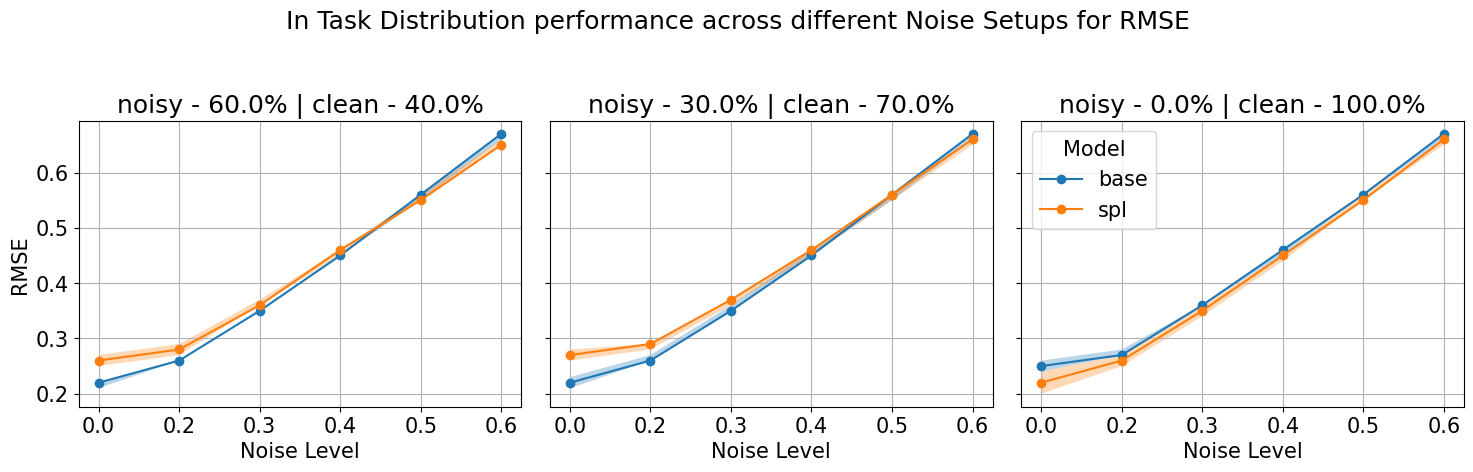

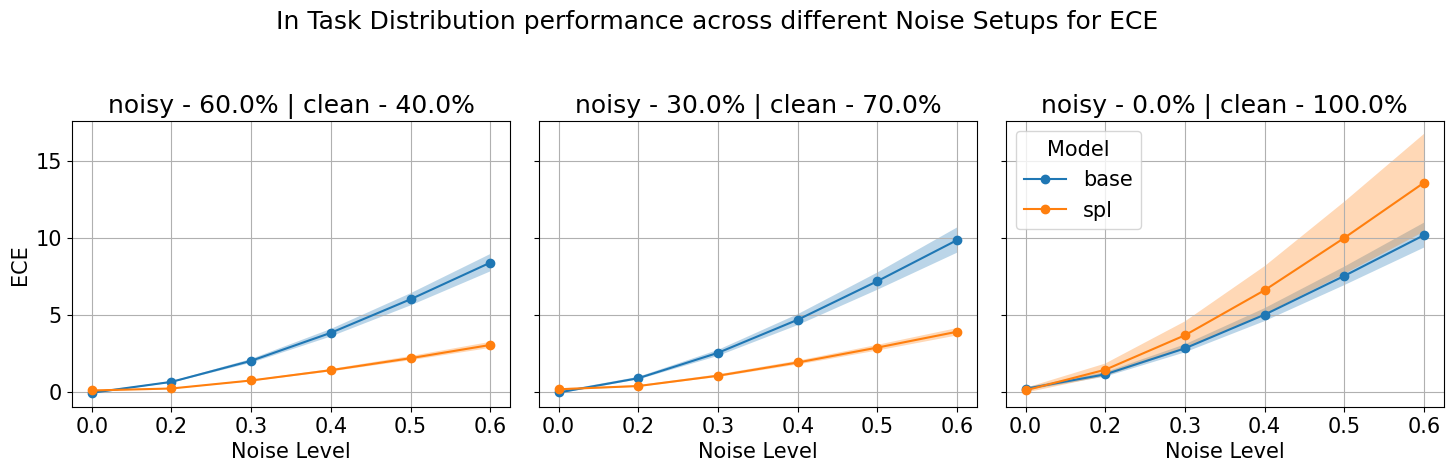

In [4]:


# Load the DataFrame
intask_eval_table_df = pd.read_pickle('intask_eval_table_df.pkl')
intask_eval_table_df.columns.names = ["Noise setup", "Noise level", "Model", "Metric"]
intask_eval_table_df.index.names = ["Metrics"]

# Plotting
noise_setups = intask_eval_table_df.columns.get_level_values('Noise setup').unique()
metrics = intask_eval_table_df.columns.get_level_values('Metric').unique()
models = intask_eval_table_df.columns.get_level_values('Model').unique()
noise_levels = intask_eval_table_df.columns.get_level_values('Noise level').unique()

plt.rcParams.update({'font.size': 15})

for metric in metrics:
    fig, axes = plt.subplots(1, len(noise_setups), figsize=(5 * len(noise_setups), 5), sharex=True, sharey=True)
    fig.suptitle(f'In Task Distribution performance across different Noise Setups for {metric.upper()}') 

    # Ensure axes is always a 2D array
    axes = np.atleast_1d(axes)

    for col, setup in enumerate(noise_setups):
        ax = axes[col]
        ax.grid(True)
        for model in models:
            means = []
            ci_lowers = []
            ci_uppers = []

            for noise_level in noise_levels:
                value_str = intask_eval_table_df.loc[:, (setup, noise_level, model, metric)].values[0]
                mean = float(value_str.split(' ')[0])
                ci_lower = float(value_str.split('(')[-1][:-1].split(',')[0])
                ci_upper = float(value_str.split('(')[-1][:-1].split(',')[1])

                means.append(mean)
                ci_lowers.append(ci_lower)
                ci_uppers.append(ci_upper)

            ax.plot(noise_levels, means, marker='o', label=f'{model}')
            ax.fill_between(noise_levels, ci_lowers, ci_uppers, alpha=0.3)

        # Extract noise levels from setup for the title

        noise_ratios = setup.split(" ")[-1].split("-")
        print(noise_ratios)
        noise_percentage = [f'{float(level) * 100:.1f}%' for level in noise_ratios]
        setup_title = f'noisy - {noise_percentage[0]} | clean - {noise_percentage[1]}'

        ax.set_title(f'{setup_title}')
        ax.set_xlabel('Noise Level')
        if col == 0:
            ax.set_ylabel(f'{metric.upper()}')
        if col == len(noise_setups) - 1:
            ax.legend(title='Model')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'intask_{metric}.png')




In [5]:
import shutil

# Define the directory name
new_dir = "eval_plots_images_dfs"

# Create the new directory if it doesn't exist
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Get the list of all files in the current directory
files_in_directory = os.listdir(".")

# Define the extensions of the files to be moved
file_extensions = [".png", ".pkl"]

# Move the files
for file_name in files_in_directory:
    if any(file_name.endswith(ext) for ext in file_extensions):
        shutil.move(file_name, os.path.join(new_dir, file_name))

print(f"Moved all {file_extensions} files to {new_dir}")

Moved all ['.png', '.pkl'] files to eval_plots_images_dfs


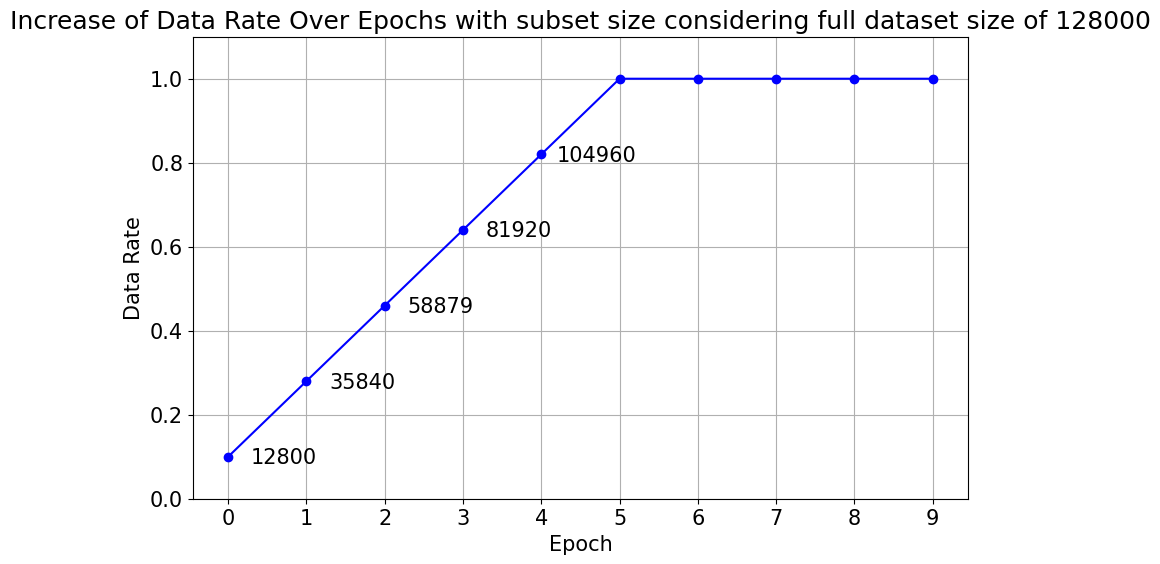

Epoch 0: 12800 data points
Epoch 1: 35840 data points
Epoch 2: 58879 data points
Epoch 3: 81920 data points
Epoch 4: 104960 data points
Epoch 5: 127999 data points
Epoch 6: 128000 data points
Epoch 7: 128000 data points
Epoch 8: 128000 data points
Epoch 9: 128000 data points


In [27]:
import matplotlib.pyplot as plt

# Define the parameters
start_rate = 0.1
growth_epochs = 5
num_epochs = 10
dataset_size = 128000

# Initialize lists to store epochs, data rates, and data points
epochs = list(range(num_epochs))
data_rates = []
data_points = []

# Calculate data rates and data points for each epoch
for epoch in epochs:
    if epoch == 0:
        data_rate = start_rate
    else:
        data_rate = min(1.0, start_rate + (1.0 - start_rate) / growth_epochs * epoch)
    data_rates.append(data_rate)
    
    # Calculate data points trained on
    data_points_trained = int(data_rate * dataset_size)
    data_points.append(data_points_trained)

# Plot the data rates over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, data_rates, marker='o', linestyle='-', color='b', label='Data Rate')
plt.title('Increase of Data Rate Over Epochs with subset size considering full dataset size of 128000')
plt.xlabel('Epoch')
plt.ylabel('Data Rate')
plt.grid(True)
plt.xticks(epochs)
plt.ylim(0, 1.1)

# Annotate each data point with the number of data points trained on
for i, (epoch, data_rate) in enumerate(zip(epochs[:5], data_rates)):
    plt.annotate(f'{data_points[i]}', (epoch, data_rate), textcoords="offset points", xytext=(40,-5), ha='center')

# Display the plot
plt.show()

# Print the data points for reference
for epoch, data_point in zip(epochs, data_points):
    print(f"Epoch {epoch}: {data_point} data points")


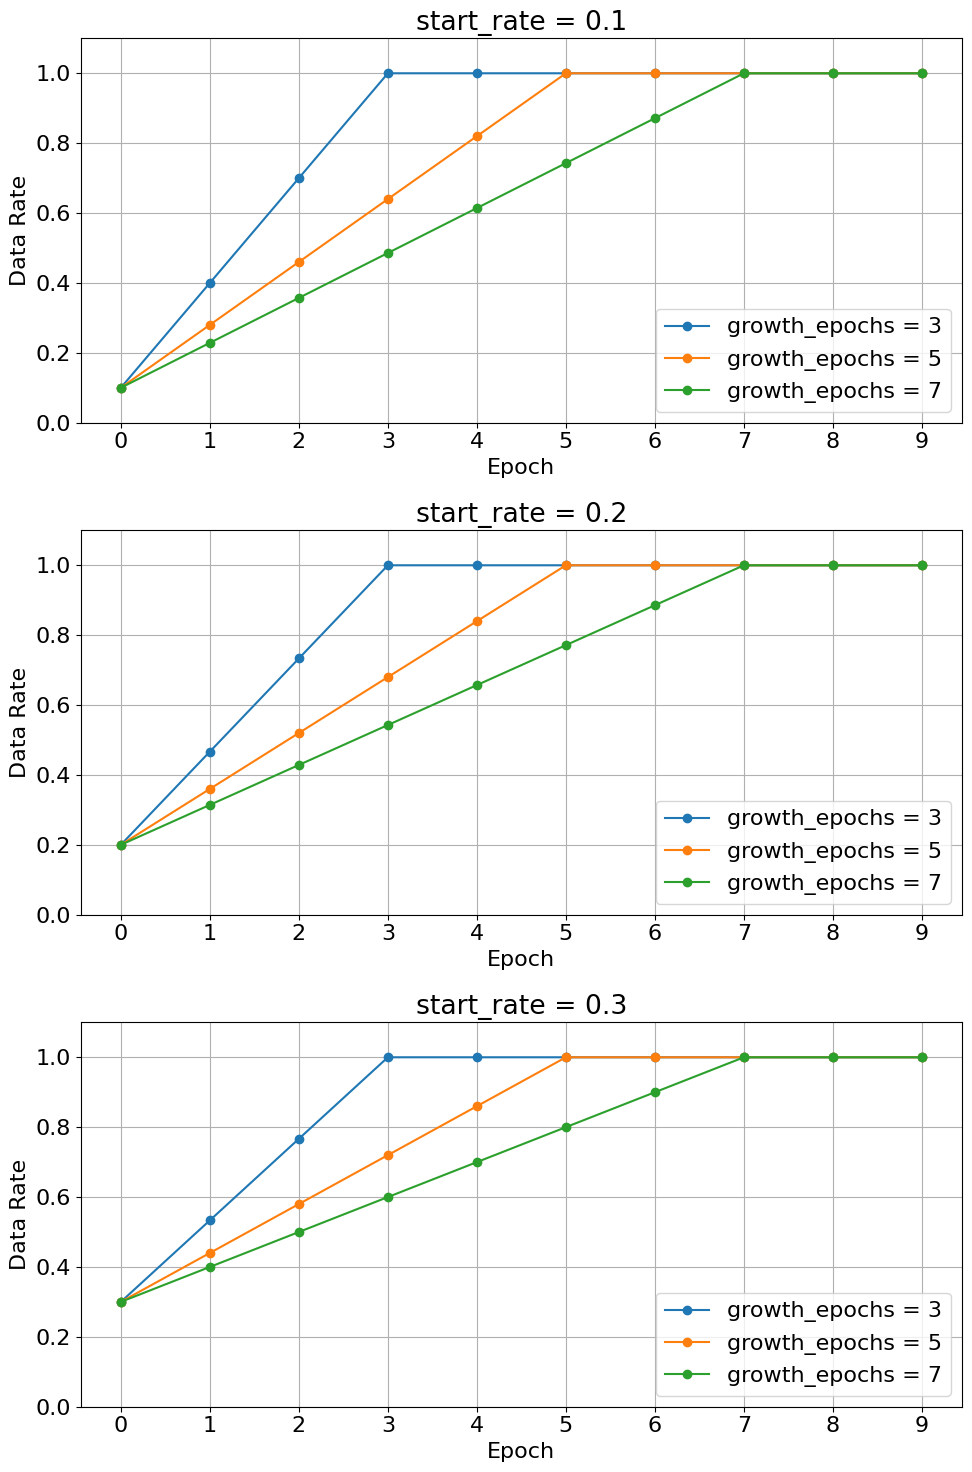

In [32]:
# Define a list of start_rates
start_rates = [0.1, 0.2, 0.3]

# Define a list of growth_epochs
growth_epochs_list = [3,5, 7,]

num_epochs = 10 

# Create a figure with subplots for each start_rate
fig, axs = plt.subplots(len(start_rates), 1, figsize=(10, len(start_rates) * 5))

# Iterate over each start_rate and plot the data rates for different growth_epochs
for i, start_rate in enumerate(start_rates):
    axs[i].set_title(f'start_rate = {start_rate}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Data Rate')
    axs[i].set_xticks(list(range(num_epochs)))
    axs[i].set_ylim(0, 1.1)
    axs[i].grid(True)
    
    for growth_epochs in growth_epochs_list:
        epochs = list(range(num_epochs))
        data_rates = []

        for epoch in epochs:
            if epoch == 0:
                data_rate = start_rate
            else:
                data_rate = min(1.0, start_rate + (1.0 - start_rate) / growth_epochs * epoch)
            data_rates.append(data_rate)
        
        axs[i].plot(epochs, data_rates, marker='o', linestyle='-', label=f'growth_epochs = {growth_epochs}')

    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

MultiIndex([('Noise setup 0.6-0.4',  'No Noise', 'base', 'rmse'),
            ('Noise setup 0.6-0.4',  'No Noise', 'base',  'ece'),
            ('Noise setup 0.6-0.4',  'No Noise',  'spl', 'rmse'),
            ('Noise setup 0.6-0.4',  'No Noise',  'spl',  'ece'),
            ('Noise setup 0.6-0.4', '0.2 Noise', 'base', 'rmse'),
            ('Noise setup 0.6-0.4', '0.2 Noise', 'base',  'ece'),
            ('Noise setup 0.6-0.4', '0.2 Noise',  'spl', 'rmse'),
            ('Noise setup 0.6-0.4', '0.2 Noise',  'spl',  'ece'),
            ('Noise setup 0.3-0.7',  'No Noise', 'base', 'rmse'),
            ('Noise setup 0.3-0.7',  'No Noise', 'base',  'ece'),
            ('Noise setup 0.3-0.7',  'No Noise',  'spl', 'rmse'),
            ('Noise setup 0.3-0.7',  'No Noise',  'spl',  'ece'),
            ('Noise setup 0.3-0.7', '0.2 Noise', 'base', 'rmse'),
            ('Noise setup 0.3-0.7', '0.2 Noise', 'base',  'ece'),
            ('Noise setup 0.3-0.7', '0.2 Noise',  'spl', 'rmse'),
          

/tmp/ipykernel_9238/2139887409.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + shift, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label='spl', capsize=5, linestyle='dashed', color='tab:orange', zorder=9)
/tmp/ipykernel_9238/2139887409.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + shift, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label='spl', capsize=5, linestyle='dashed', color='tab:orange', zorder=9)
/tmp/ipykernel_9238/2139887409.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + shift, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label=

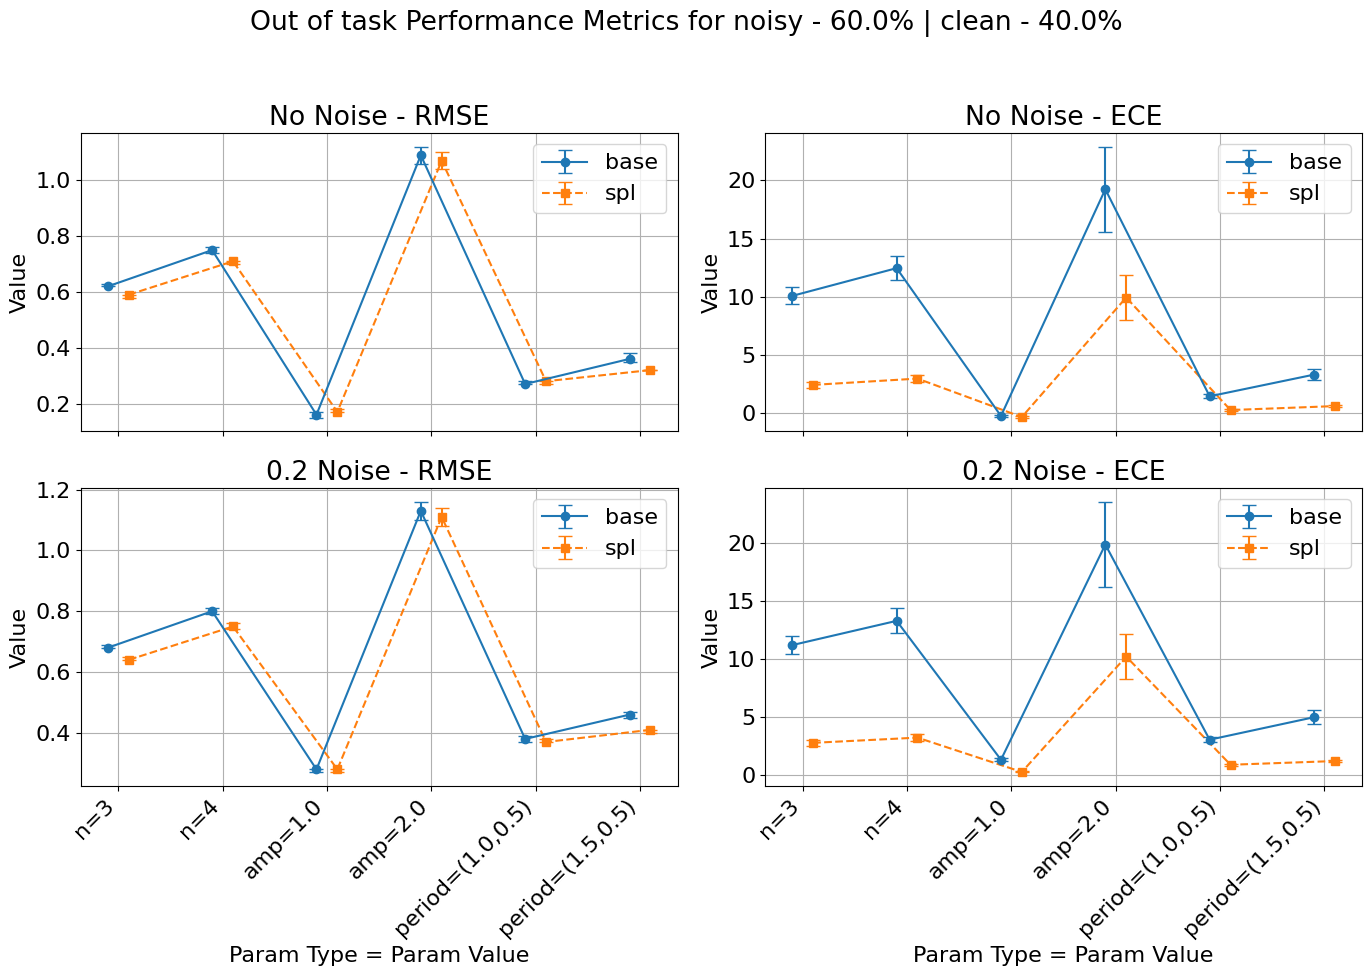

['0.3', '0.7']


/tmp/ipykernel_9238/2139887409.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + shift, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label='spl', capsize=5, linestyle='dashed', color='tab:orange', zorder=9)
/tmp/ipykernel_9238/2139887409.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + shift, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label='spl', capsize=5, linestyle='dashed', color='tab:orange', zorder=9)
/tmp/ipykernel_9238/2139887409.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + shift, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label=

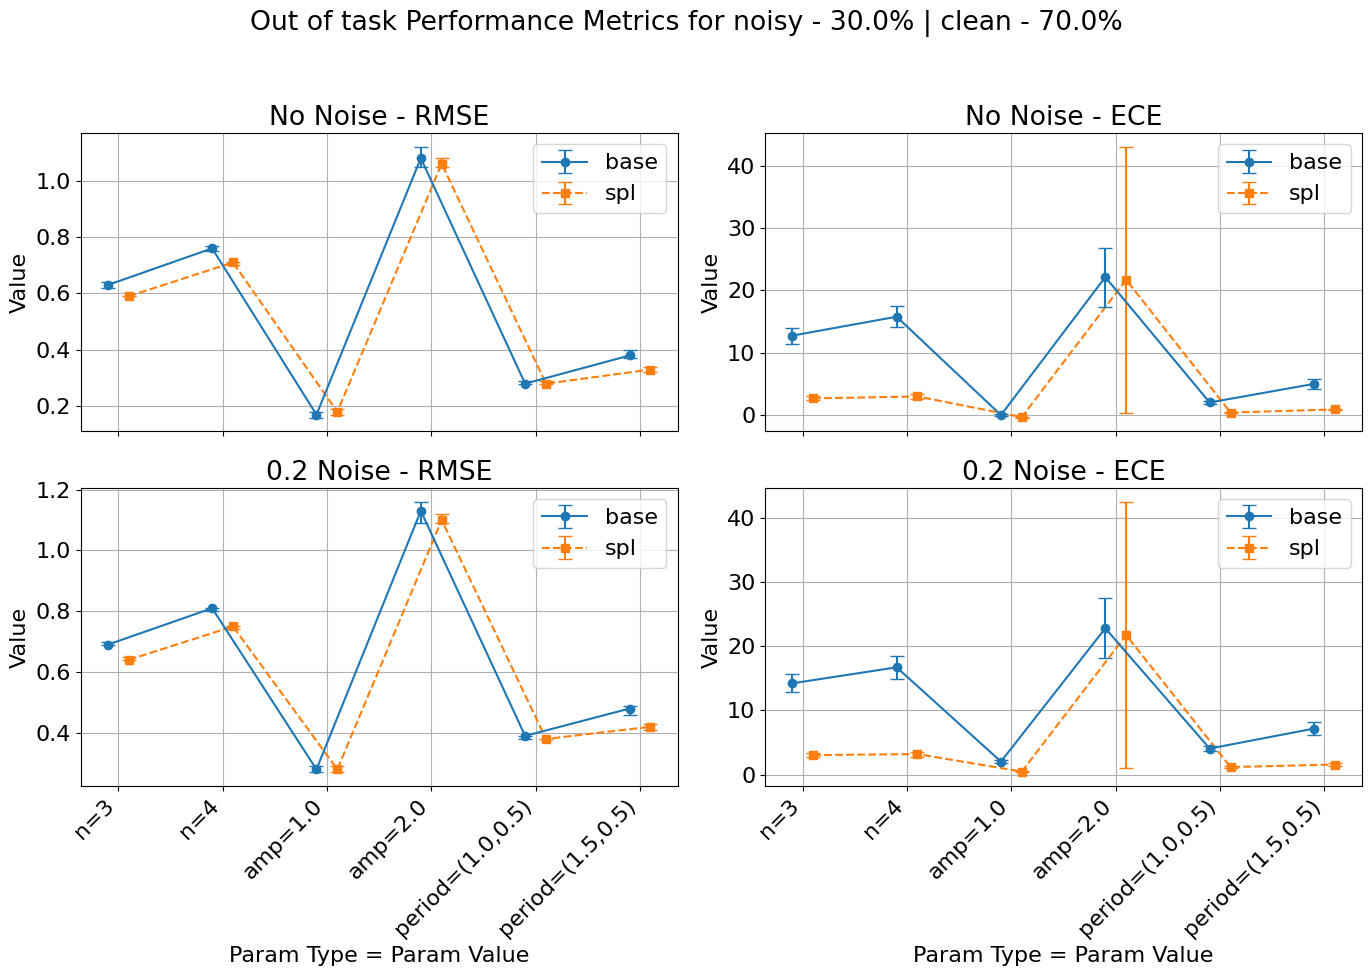

['0', '1']


/tmp/ipykernel_9238/2139887409.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + shift, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label='spl', capsize=5, linestyle='dashed', color='tab:orange', zorder=9)
/tmp/ipykernel_9238/2139887409.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + shift, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label='spl', capsize=5, linestyle='dashed', color='tab:orange', zorder=9)
/tmp/ipykernel_9238/2139887409.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + shift, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label=

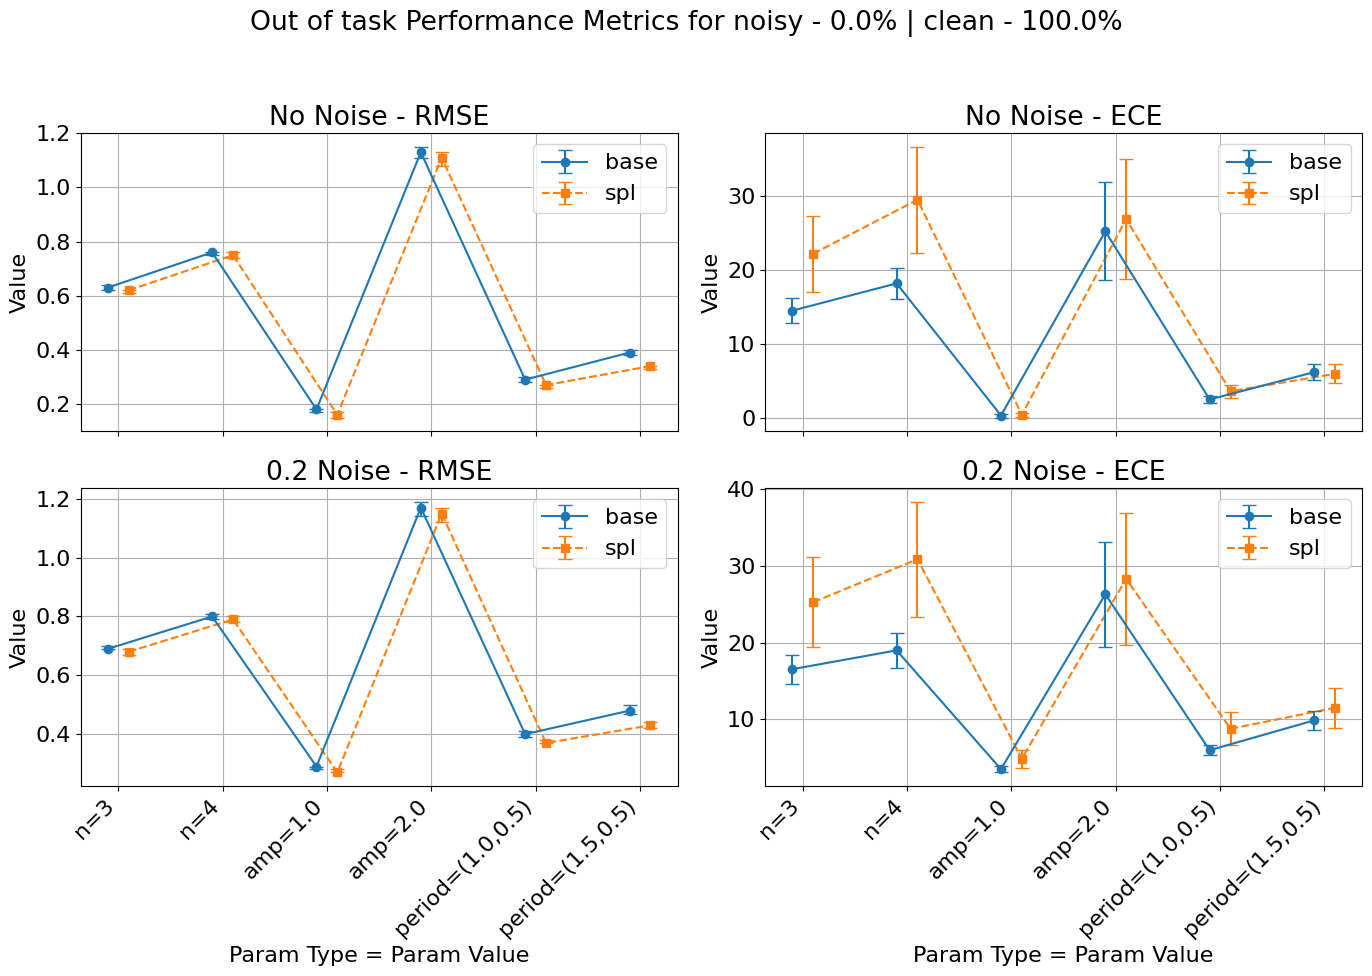

In [38]:
# Load the dataframe
eval_table_df = pd.read_pickle('eval_plots_images_dfs/eval_table_df.pkl').T

plt.rcParams.update({'font.size': 16})

print(eval_table_df.index)
print(eval_table_df.columns)

# Helper function to parse the mean and confidence intervals from the string
def parse_metric_string(metric_str):
    mean_str, ci_str = metric_str.split(' (')
    mean_val = float(mean_str)
    ci_str = ci_str.rstrip(')')
    ci_lower, ci_upper = map(float, ci_str.split(', '))
    return mean_val, ci_lower, ci_upper

# Function to extract data for plotting
def extract_plot_data(df, noise_setup, noise_level, metric):
    param_types_values = []
    means_base = []
    lower_base = []
    upper_base = []
    means_spl = []
    lower_spl = []
    upper_spl = []

    for (param_type, param_value) in df.index:
        param_types_values.append(f'{param_type}={param_value}')
        try:
            base_metric_str = df.loc[(param_type, param_value), (noise_setup, noise_level, 'base', metric)]
            spl_metric_str = df.loc[(param_type, param_value), (noise_setup, noise_level, 'spl', metric)]

            base_mean, base_lower, base_upper = parse_metric_string(base_metric_str)
            spl_mean, spl_lower, spl_upper = parse_metric_string(spl_metric_str)

            means_base.append(base_mean)
            lower_base.append(base_mean - base_lower)
            upper_base.append(base_upper - base_mean)
            means_spl.append(spl_mean)
            lower_spl.append(spl_mean - spl_lower)
            upper_spl.append(spl_upper - spl_mean)
        except KeyError:
            means_base.append(np.nan)
            lower_base.append(np.nan)
            upper_base.append(np.nan)
            means_spl.append(np.nan)
            lower_spl.append(np.nan)
            upper_spl.append(np.nan)

    return param_types_values, means_base, lower_base, upper_base, means_spl, lower_spl, upper_spl

# Function to plot metrics
def plot_metrics(df, noise_setup):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    noise_ratios = noise_setup.split(" ")[-1].split("-")
    print(noise_ratios)
    noise_percentage = [f'{float(level) * 100:.1f}%' for level in noise_ratios]
    setup_title = f'noisy - {noise_percentage[0]} | clean - {noise_percentage[1]}'

    fig.suptitle(f'Out of task Performance Metrics for {setup_title}')

    metrics = ['rmse', 'ece']
    noise_levels = ['No Noise', '0.2 Noise']
    
    for i, noise_level in enumerate(noise_levels):
        for j, metric in enumerate(metrics):
            ax = axs[i, j]
            ax.set_title(f'{noise_level} - {metric.upper()}')
            ax.grid(True)
            ax.set_ylabel('Value')
            if i == 1:
                ax.set_xlabel('Param Type = Param Value')

            # Extract data for the specific noise level and metric
            param_types_values, means_base, lower_base, upper_base, means_spl, lower_spl, upper_spl = extract_plot_data(df, noise_setup, noise_level, metric)
            x = np.arange(len(param_types_values))
            shift = 0.1  # Adjust this value to control the shift
            
            # Plot base with blue color slightly shifted to the left
            ax.errorbar(x - shift, means_base, yerr=[lower_base, upper_base], fmt='-o', label='base', capsize=5, color='tab:blue', zorder=10)
            
            # Plot spl with orange color slightly shifted to the right
            ax.errorbar(x + shift, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label='spl', capsize=5, linestyle='dashed', color='tab:orange', zorder=9)
            
            ax.set_xticks(x)
            ax.set_xticklabels(param_types_values, rotation=45, ha='right')
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'out_of_task_metrics_{noise_setup}.png')
    plt.show()

# Load the dataframe
eval_table_df = pd.read_pickle('eval_plots_images_dfs/eval_table_df.pkl')

# Verify the structure of the DataFrame
print(eval_table_df.columns)
print(eval_table_df.columns.levels)
print("------")
print(eval_table_df.index.names)
print(eval_table_df.index.levels)

# Initialize the noise setups
noise_setups = eval_table_df.columns.get_level_values('Noise setup').unique()
print("Noise setups:", noise_setups)

# Loop over each noise setup to create separate figures
for noise_setup in noise_setups:
    plot_metrics(eval_table_df, noise_setup)

['0.6', '0.4']
['0.3', '0.7']
['0', '1']


/tmp/ipykernel_16429/287022843.py:85: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + width/2, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label=f'spl', capsize=5, linestyle='dashed', color='tab:orange', zorder=9)
/tmp/ipykernel_16429/287022843.py:85: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + width/2, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label=f'spl', capsize=5, linestyle='dashed', color='tab:orange', zorder=9)
/tmp/ipykernel_16429/287022843.py:85: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x + width/2, means_spl, yerr=[lower_spl, upper_spl], fmt='-s'

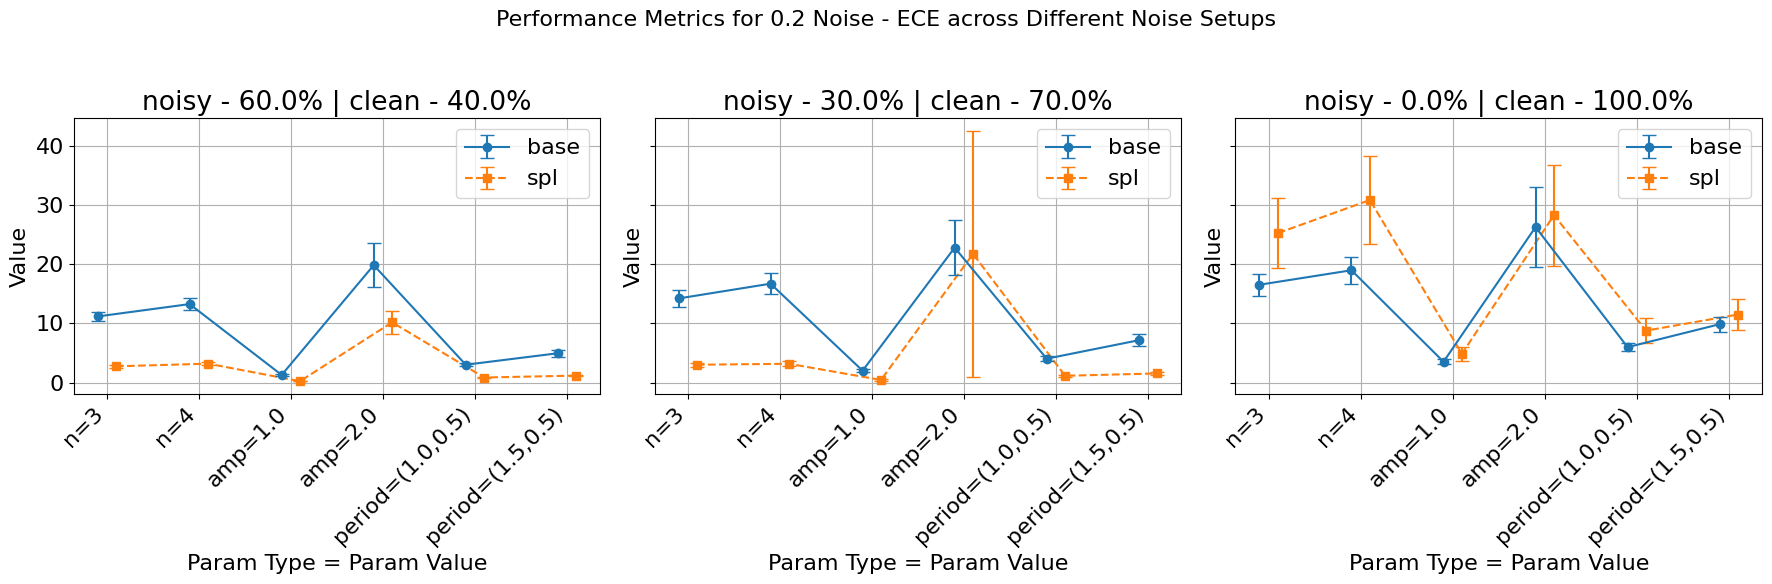

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the dataframe
eval_table_df = pd.read_pickle('eval_plots_images_dfs/eval_table_df.pkl')

plt.rcParams.update({'font.size': 16})

# Helper function to parse the mean and confidence intervals from the string
def parse_metric_string(metric_str):
    mean_str, ci_str = metric_str.split(' (')
    mean_val = float(mean_str)
    ci_str = ci_str.rstrip(')')
    ci_lower, ci_upper = map(float, ci_str.split(', '))
    return mean_val, ci_lower, ci_upper

# Function to extract data for plotting
def extract_plot_data(df, noise_setup, noise_level, metric):
    param_types_values = []
    means_base = []
    lower_base = []
    upper_base = []
    means_spl = []
    lower_spl = []
    upper_spl = []

    for (param_type, param_value) in df.index:
        param_types_values.append(f'{param_type}={param_value}')
        try:
            base_metric_str = df.loc[(param_type, param_value), (noise_setup, noise_level, 'base', metric)]
            spl_metric_str = df.loc[(param_type, param_value), (noise_setup, noise_level, 'spl', metric)]

            base_mean, base_lower, base_upper = parse_metric_string(base_metric_str)
            spl_mean, spl_lower, spl_upper = parse_metric_string(spl_metric_str)

            means_base.append(base_mean)
            lower_base.append(base_mean - base_lower)
            upper_base.append(base_upper - base_mean)
            means_spl.append(spl_mean)
            lower_spl.append(spl_mean - spl_lower)
            upper_spl.append(spl_upper - spl_mean)
        except KeyError:
            means_base.append(np.nan)
            lower_base.append(np.nan)
            upper_base.append(np.nan)
            means_spl.append(np.nan)
            lower_spl.append(np.nan)
            upper_spl.append(np.nan)

    return param_types_values, means_base, lower_base, upper_base, means_spl, lower_spl, upper_spl

# Function to plot metrics for all noise setups in a single row horizontally aligned
def plot_metrics_all_setups_horizontal(df):
    metrics = ['ece']
    noise_levels = ['0.2 Noise']
    num_noise_setups = len(df.columns.get_level_values('Noise setup').unique())
    
    fig, axs = plt.subplots(1, num_noise_setups, figsize=(6*num_noise_setups, 6), sharey=True)
    fig.suptitle('Performance Metrics for 0.2 Noise - ECE across Different Noise Setups', fontsize=16)
    
    for i, noise_setup in enumerate(df.columns.get_level_values('Noise setup').unique()):
        ax = axs[i] if num_noise_setups > 1 else axs  # Handle single subplot case
        noise_ratios = noise_setup.split(" ")[-1].split("-")
        print(noise_ratios)
        noise_percentage = [f'{float(level) * 100:.1f}%' for level in noise_ratios]
        setup_title = f'noisy - {noise_percentage[0]} | clean - {noise_percentage[1]}'

        ax.set_title(f'{setup_title}')
        ax.grid(True)
        ax.set_ylabel('ECE')
        ax.set_xlabel('Param Type = Param Value')

        for noise_level in noise_levels:
            for metric in metrics:
                # Extract data for the specific noise level and metric
                param_types_values, means_base, lower_base, upper_base, means_spl, lower_spl, upper_spl = extract_plot_data(df, noise_setup, noise_level, metric)
                x = np.arange(len(param_types_values))
                width = 0.2  # Width of the bars

                # Plot base with blue color slightly shifted to the left
                ax.errorbar(x - width/2, means_base, yerr=[lower_base, upper_base], fmt='-o', label=f'base', capsize=5, color='tab:blue', zorder=10)
                
                # Plot spl with orange color slightly shifted to the right
                ax.errorbar(x + width/2, means_spl, yerr=[lower_spl, upper_spl], fmt='-s', label=f'spl', capsize=5, linestyle='dashed', color='tab:orange', zorder=9)
                
                ax.set_xticks(x)
                ax.set_xticklabels(param_types_values, rotation=45, ha='right')
                ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('out_of_task_metrics_all_setups_horizontal.png')
    plt.show()

# Plot metrics for all noise setups in a single row horizontally aligned
plot_metrics_all_setups_horizontal(eval_table_df)